In [671]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import ast
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from wordcloud import WordCloud

#NLP libraries
import spacy, nltk, gensim
import pyLDAvis.gensim_models
from nltk import word_tokenize
from nltk.collocations import *
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('punkt')

import datetime as dt

Supplementary Packages needed : <br>
* SPARQLWrapper
* scikit-learn
* wordcloud
* spacy
* gensim
* pyLDAvis
* python3 -m spacy download en_core_web_sm


# **STEP 0: Data opening and preprocessing**

The data in the CMU Movie Summary Corpus contains a collection of 42,306 movie plot summaries and metadata at both the movie level (including box office revenues, genre and date of release) and character level (including gender and estimated age):

**Data:**
1. `plot_summaries.txt.gz` [29 M]: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.
2. `corenlp_plot_summaries.tar.gz` [628 M, separate download]: to downlaod if considered useful... The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

**Metadata:**
1. `movie.metadata.tsv.gz` [3.4 M]: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)
2. `character.metadata.tsv.gz` [14 M]: Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

**Test data**:
1. `tvtropes.clusters.txt`: 72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.
2. `name.clusters.txt`: 970 unique character names used in at least two different movies, along with 2,666 instances of those types. The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

## Data loading

In [672]:
data_folder = './MovieSummaries/'

#### `characters`

In [673]:
characters = pd.read_csv(data_folder + 'character.metadata.tsv', sep='\t', header=None)
characters.columns =['Wikipedia_movie_ID', 
                     'Freebase_movie_ID', 
                     'Movie_release_date', 
                     'Character_name', 
                     'Actor_birth', 
                     'Actor_Gender', 
                     'Actor Height', 
                     'Actor_Ethnicity', 
                     'Actor_Name', 
                     'Age_at_movie_release', 
                     'Freebase_character_actor_map_ID', 
                     'Freebase_character_ID', 
                     'Freebase_actor_ID']

#### `movies`

In [674]:
movies = pd.read_csv(data_folder + 'movie.metadata.tsv', sep='\t', header=None)
movies.columns =['Wikipedia_movie_ID', 
                 'Freebase_movie_ID', 
                 'Name',
                 'Release_date', 
                 'Box_office_revenue', 
                 'Runtime',
                 'Languages', 
                 'Countries', 
                 'Genres']

#### `plot_summaries`

In [675]:
plot_summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep='\t', header=None)
plot_summaries.columns =['Wikipedia_movie_ID', 'Summary']

#### `character_types`

In [676]:
character_types = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep='\t', header=None)
character_types.columns =['Type', 'Info']

#### `name_clusters`

In [677]:
name_clusters = pd.read_csv(data_folder + 'name.clusters.txt', sep='\t', header=None)
name_clusters.columns =['Character_name', 'Freebase_character_actor_map_ID']

## Dataframes pre-processing 

### About Nan values

Below we will observe that many columns contain null values resulting in a lot of rows having one or more missing features. In order to keep a maximum of information, we will not drop all the rows having at least one null value in their features because the other respective features might still be useful individually depending on what information we want to analyse. In fact we can see in the example below that dropping these rows will result in a big loss of information. However, the null values will be handled directly when working on particular features with subsets of the original dataframe.

In [678]:
len(movies)

81741

In [679]:
len(movies.dropna())

8243

Indeed we would loose almost 90% of the rows if we removed the rows containing at least one NAN value.

### `characters` 

Each row is a character paired to an actor in a single movie, columns correspond to features that describe the characters, the actor that embodies them and the movie in which they appear. To get a better understanding, note that a single character can be played by multiple actors (e.g. James Bond) and that a single actor can have multiple roles. 

In [680]:
characters.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


In [681]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia_movie_ID               450669 non-null  int64  
 1   Freebase_movie_ID                450669 non-null  object 
 2   Movie_release_date               440674 non-null  object 
 3   Character_name                   192794 non-null  object 
 4   Actor_birth                      344524 non-null  object 
 5   Actor_Gender                     405060 non-null  object 
 6   Actor Height                     154824 non-null  float64
 7   Actor_Ethnicity                  106058 non-null  object 
 8   Actor_Name                       449441 non-null  object 
 9   Age_at_movie_release             292556 non-null  float64
 10  Freebase_character_actor_map_ID  450669 non-null  object 
 11  Freebase_character_ID            192804 non-null  object 
 12  Fr

Note that only the features `Wikipedia_movie_ID`, `Freebase_movie_ID` and `Freebase_character_actor_map_ID` do not contain missing values. <br>
In particular, we can see below that only `Freebase_character_actor_map_ID` values are all unique. In fact this mapping ID is uniquely created for each single movie. <br>
Surprisingly the number of unique `Actor_Name` is greater than the number of unique `Character_name`. However, the number of unique `Freebase_character_ID` is lower than the `Freebase_actor_ID`. The latter was expected since an actor can have multiple roles. <br>
We can also observe that the difference between the number of actor names (134'078) and the number of freebase actor ids (135'760, unique by definition) is different. Thus we can expect some actors to have the same name but to be different people having different ids (observe in the second cell below that there are 1240 names of actors that are associated to 2 or more different freebase actor ids.). The same is expected for characters but with more occurence. For example 'Bob' is more likely to be the name of multiple different characters than 'Roger Moore' is to be the name of multiple different actors.

In [682]:
characters.nunique()

Wikipedia_movie_ID                  64330
Freebase_movie_ID                   64330
Movie_release_date                  18476
Character_name                     126629
Actor_birth                         29494
Actor_Gender                            2
Actor Height                          221
Actor_Ethnicity                       479
Actor_Name                         134078
Age_at_movie_release                  155
Freebase_character_actor_map_ID    450669
Freebase_character_ID              183435
Freebase_actor_ID                  135760
dtype: int64

The output below is a good example to understand the subtility of this dataframe. Each row contains the information of an actor that played a particular character in a particular movie. Thus, if an actor plays the same character that appears in n movies, there will be n rows to describe their relationships where not only the features related to the movie will change, but also their map ids. This shows the specificity of this feature that describes a unique triplet of [actor, character, movie].

In [683]:
characters.loc[characters.Actor_Name == 'Roger Moore'].query("Character_name == 'James Bond'")

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
31341,6446062,/m/01kf3_9,1979-06-26,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,51.0,/m/02xg8wv,/m/0clpml,/m/017lqp
69068,6446044,/m/0g5pv3,1981-06-24,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,53.0,/m/02xg8x3,/m/0clpml,/m/017lqp
124179,583932,/m/02sg5v,1985-05-22,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,57.0,/m/02xg8xd,/m/0clpml,/m/017lqp
149343,6223567,/m/0fxmbn,1974-12-19,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,47.0,/m/02xg8w8,/m/0clpml,/m/017lqp
202846,6446061,/m/0g5pvv,1973-06-27,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,45.0,/m/02xg8v_,/m/0clpml,/m/017lqp
234294,541642,/m/02n72k,1983-06-06,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,55.0,/m/02k8g9d,/m/0clpml,/m/017lqp
425243,6446036,/m/0g5ptf,1977-07-07,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,49.0,/m/02xg8wk,/m/0clpml,/m/017lqp


Now that we have understood the structure of the `characters` dataframe, we would like to retrieve the wikidata items corresponding to the freebase IDs contained in `Actor_Ethnicity`, to add an extra feature to our dataframe. To do so we will use the wikidata query service through the sparqlwrapper package.

In [684]:
#print all freebase with format corresponding to the wikidata query service. Then manually copy pasted
ethnicity_id = list(characters['Actor_Ethnicity'].value_counts().index)
for e in ethnicity_id : print('"'+e+'"',end=' ') # to copy-paste below

"/m/0dryh9k" "/m/0x67" "/m/041rx" "/m/02w7gg" "/m/033tf_" "/m/0xnvg" "/m/02ctzb" "/m/07hwkr" "/m/07bch9" "/m/044038p" "/m/03bkbh" "/m/0d7wh" "/m/03ts0c" "/m/0222qb" "/m/01rv7x" "/m/02sch9" "/m/04mvp8" "/m/03lmx1" "/m/065b6q" "/m/01qhm_" "/m/06mvq" "/m/048z7l" "/m/0bpjh3" "/m/0cqgdq" "/m/0g8_vp" "/m/09vc4s" "/m/013xrm" "/m/019kn7" "/m/06gbnc" "/m/07mqps" "/m/01g7zj" "/m/01xhh5" "/m/03bx0k4" "/m/0g96wd" "/m/02g7sp" "/m/09m6hr" "/m/063k3h" "/m/0g0x7_" "/m/03ttfc" "/m/023mqw" "/m/0d2by" "/m/09kr66" "/m/042gtr" "/m/025rpb0" "/m/08hpk0" "/m/038723" "/m/0583cz" "/m/022dp5" "/m/0cmdl5l" "/m/03vv99" "/m/029f2r" "/m/09k5jvk" "/m/0cnvdq1" "/m/06v41q" "/m/04gfy7" "/m/0bymc" "/m/0cn68" "/m/09v5bdn" "/m/05l3g_" "/m/0268_k" "/m/0dqqwy" "/m/075_n6" "/m/0bbz66j" "/m/02rbdlq" "/m/0bkbz" "/m/01336l" "/m/04dbw3" "/m/0fqz6" "/m/06j2v" "/m/046cwm" "/m/0g6ff" "/m/0432mrk" "/m/0gkxl2" "/m/02p1pl6" "/m/03w9bjf" "/m/04tvpv" "/m/027n1m6" "/m/09743" "/m/0bhsnb" "/m/013b6_" "/m/048sp5" "/m/0h2138" "/m/02y_9mh" "/m

In [685]:
#https://rdflib.github.io/sparqlwrapper/

#Below the query is made in two steps to respect the maximal size of the function's capacity

endpoint_url = "https://query.wikidata.org/sparql"

query1 = """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?id ?itemLabel WHERE {
  VALUES ?id {"/m/044038p" "/m/075_n6" "/m/0bbz66j" "/m/02rbdlq" "/m/0bkbz" "/m/01336l" "/m/04dbw3" "/m/0fqz6" "/m/06j2v" "/m/046cwm" "/m/0g6ff" "/m/0432mrk" "/m/0gkxl2" "/m/02p1pl6" "/m/03w9bjf" "/m/04tvpv" "/m/027n1m6" "/m/09743" "/m/0bhsnb" "/m/013b6_" "/m/048sp5" "/m/0h2138" "/m/02y_9mh" "/m/02jvpv" "/m/0dbxy" "/m/02vsw1" "/m/08cjt2" "/m/013s3n" "/m/09zyn5" "/m/0cm7w1" "/m/04q7gbh" "/m/0fj1k9" "/m/0fqp6zk" "/m/04f581" "/m/012c1l" "/m/071x0k" "/m/0ffjqy" "/m/0ffkb4" "/m/0g5y6" "/m/0bzkm2" "/m/0dllcfn" "/m/04y8_bm" "/m/03gskx0" "/m/0268d21" "/m/019lrz" "/m/02p4q5p" "/m/04czx7" "/m/02p656s" "/m/0ffhz3" "/m/04jq32s" "/m/04mmhj" "/m/0dj8k3" "/m/059_w" "/m/01kg2v" "/m/0222hg" "/m/0f0gt_" "/m/01j2qv" "/m/0ffjvd" "/m/032j30" "/m/033njm" "/m/0bs7l_v" "/m/0g48m4" "/m/022fdt" "/m/052r3t" "/m/0bfjm7" "/m/01xttr" "/m/04ydrsn" "/m/03295l" "/m/06lshc" "/m/03cbkrf" "/m/0283js_" "/m/09cqth" "/m/04nrnz" "/m/05748" "/m/025_0f0" "/m/01trsl" "/m/09vmyh" "/m/05sf2x" "/m/09gk_6h" "/m/078vc" "/m/01p7s6" "/m/017sq0" "/m/018s6c" "/m/04y29" "/m/067lts" "/m/05g0f1" "/m/0761bp" "/m/09gp4" "/m/02qv_h_" "/m/0640_7q" "/m/0912ll" "/m/013b7g" "/m/067lrj" "/m/0b79c7" "/m/09lz9zx" "/m/01swvz" "/m/01nbcy" "/m/0b0gzf" "/m/071drf" "/m/027vy0s" "/m/0150zs" "/m/0278pqj" "/m/0747611" "/m/0c2hxm" "/m/0462jl6" "/m/074w_m" "/m/04ggbzy" "/m/0hbz9xw" "/m/0152s7" "/m/0fng3k" "/m/0j4w_" "/m/0b98sy" "/m/08v2k7" "/m/0j6x8" "/m/0d9q7j" "/m/016f5d" "/m/0ffj5g" "/m/0338zd" "/m/04_tz7" "/m/027lf0d" "/m/0ch3pqf" "/m/06fczy" "/m/01mw1s" "/m/04608z" "/m/04_hr_" "/m/026cybk" "/m/01hwt" "/m/08gzsf" "/m/05vhv7" "/m/04_bc8" "/m/06rd7" "/m/0318mh" "/m/02wcbj_" "/m/0520604" "/m/07j80c" "/m/078ds" "/m/0fk1z" "/m/0dv5vw" "/m/04znbg" "/m/01sq7s" "/m/0gf5k1" "/m/03pqwy" "/m/031_sd" "/m/012f86" "/m/092h2qt" "/m/033qxt" "/m/03vghh" "/m/0bjbszh" "/m/07hyjp" "/m/03yk6g" "/m/0h1nk0k" "/m/04zjjt" "/m/02czfr" "/m/05qb937" "/m/047l_90" "/m/0bnzjx" "/m/02q206y" "/m/0665pp" "/m/07gzw5" "/m/062_25" "/m/0hj35" "/m/0bh91q8" "/m/01g0y_" "/m/07lv5x" "/m/0g4pffv" "/m/0828vj" "/m/07d_p8" "/m/04lhn7b" "/m/0fq6zlv" "/m/0268pvf" "/m/0466nw8" "/m/04pnf" "/m/02p_gby" "/m/06k6sl" "/m/0738n4" "/m/0266mf0" "/m/0cx3p" "/m/04kbvpz" "/m/07s9g04" "/m/04l_pt" "/m/026c9dq" "/m/01ylpf" "/m/0g5k7qv" "/m/01tyl3" "/m/0b__fv3" "/m/02vkd28" "/m/013s41" "/m/047948f" "/m/067lwk" "/m/03d19xz" "/m/02gx2x" "/m/021pd" "/m/013s2p" "/m/09fqz7" "/m/0ffhvl" "/m/075dhf0" "/m/02dd5z" "/m/03wbmrc" "/m/0br_8h" "/m/097nms" "/m/02cm28" "/m/0h6mqq9" "/m/09tqq8q" "/m/0301y_" "/m/0d8qh0" "/m/03h1dq9" "/m/03fk0c" "/m/026kx7g" "/m/04k02l" "/m/051wcch" "/m/026zlyd" "/m/01n94b" "/m/04dzwby" "/m/0btrm4" "/m/03ndvw" "/m/0fxmtg" "/m/04sfz4s" "/m/03cnzsg" "/m/03r_k" "/m/03f3sf" "/m/04lfc70" "/m/02vkw95" "/m/09y7x4" "/m/0fk3s" "/m/0h8mzsl" "/m/02p444n" "/m/03kbr" "/m/0bns36b" "/m/0bbcnlt" "/m/046j25" "/m/0dq1q" "/m/02rdfpy" "/m/05c60ml" "/m/0470lk" "/m/02p7gyv" "/m/0c29q8" "/m/03ck8x1" "/m/042199j" "/m/0bms44" "/m/01nft3" "/m/01d7kx" "/m/01c034" "/m/05cc9h" "/m/03cl2pz" "/m/03x_lpj" "/m/02rp50t" "/m/03m3p6w" "/m/02r_qms" "/m/086wp0" "/m/065z7w_" "/m/01f9bg" "/m/03sx6v" "/m/034s7b" "/m/0987ctr" "/m/03gy1h2" "/m/0c_lbq" "/m/03ftx7" "/m/067lv3" "/m/0g44f5" "/m/03d26m9" "/m/0165md" "/m/0dqrh8" "/m/0cc5y74" "/m/0289z8v" "/m/01267" "/m/0fpjs3j" "/m/03cdk7b" "/m/0bfrrj" "/m/04wy6k" "/m/03zcwh" "/m/0dc58y8" "/m/0g5rkt4" "/m/0647lm" "/m/04fh1b" "/m/047bp1r" "/m/09cd0m" "/m/03fvrb" "/m/025x6k1" "/m/02rm7_9" "/m/01l0ty" "/m/07s49c2" "/m/03ty8_" "/m/02m0kh" "/m/05ms3p0" "/m/0gtwjz6" "/m/0ftlzz" "/m/02pzb09" "/m/05sycg" "/m/051x6yk" "/m/01vsch" "/m/04csgrq" "/m/064b9n" "/m/09chmw" "/m/095mw2" "/m/09snp5" "/m/025tvhm" "/m/0c41n" "/m/01_5cg" "/m/025xss1" "/m/0404kdr" "/m/0ftwg" "/m/0790v" "/m/02r3wfk" "/m/03h11s3" "/m/01vr3v" "/m/0c3wsgg" "/m/06y24j" "/m/0ckk60" "/m/03lnnd" "/m/04hlx1" "/m/062zk4r" "/m/097r55" "/m/0b8yvr" "/m/0br_9j" "/m/0xff" "/m/01crfj" "/m/05mtdy" "/m/065577s" "/m/0fp4n" "/m/0301xt" "/m/01kb9y" "/m/0268xtg" "/m/05y2yj" "/m/0ffk5n" "/m/02vys3l" "/m/01h4n" "/m/0bvnws" "/m/06dy2k" "/m/08yg47" "/m/08c25t" "/m/0bvjpj" "/m/03x1x" "/m/0dn1_0" "/m/02qv716" "/m/02r11hz" "/m/06bkf" "/m/035b50" "/m/0166vx" "/m/01g3rx" "/m/06w4lv" "/m/04wysy" "/m/064pj" "/m/013z8m" "/m/04118b" "/m/064rb5l" "/m/01ywdy" "/m/01flqq" "/m/0960kn" "/m/0180zw" "/m/0463n9y" "/m/0d32d1" "/m/07n8wy" "/m/03q819" "/m/06vb7b" "/m/02pj9yr" "/m/03hf_6z" "/m/01km_m" "/m/062szv5" "/m/07g8yp" "/m/0fk55" "/m/04lgl9t" "/m/0444sm4" "/m/03m9my8" "/m/03cjjy0" "/m/03cmqbt" "/m/0b3zsn" "/m/03b_13l" "/m/0152wh" "/m/05ysft4" "/m/05sng" "/m/059v8" "/m/09c8kp" "/m/04jtjvt" "/m/04c28" "/m/03sk2" "/m/05ztd1" "/m/0dm3xpw" "/m/03hjx6f" "/m/026d074" "/m/03nvq" "/m/03nz70" "/m/029q52" "/m/02wz7j" "/m/04kdwcx" "/m/02ry8mk" "/m/07wsyr" "/m/09r2kh" "/m/04_8lfc" "/m/033qt1" "/m/012fh" "/m/08j1fb" "/m/027936c" "/m/0dtkkb" "/m/05bzpzx" "/m/04lhnps" "/m/0fp54b" "/m/01hm_" "/m/0288fw3" "/m/0ft9bs" "/m/01gr8h" "/m/09g34_" "/m/0d8qls" "/m/08xbxs" "/m/032m0b" "/m/04hqxn" "/m/068y7m" "/m/044bp_" "/m/039z49" "/m/047q05d" "/m/0c50f" "/m/01srl7" "/m/0fpxlz9" "/m/0bdynxs" "/m/01gby2" "/m/043_z22" "/m/03x_fq7" "/m/01hphz" "/m/033fjj" "/m/013y54"}.
   ?item wdt:P646 ?id.
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

query2 = """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?id ?itemLabel WHERE {
  VALUES ?id {"/m/0dryh9k" "/m/0x67" "/m/041rx" "/m/02w7gg" "/m/033tf_" "/m/0xnvg" "/m/02ctzb" "/m/07hwkr" "/m/07bch9" "/m/044038p" "/m/03bkbh" "/m/0d7wh" "/m/03ts0c" "/m/0222qb" "/m/01rv7x" "/m/02sch9" "/m/04mvp8" "/m/03lmx1" "/m/065b6q" "/m/01qhm_" "/m/06mvq" "/m/048z7l" "/m/0bpjh3" "/m/0cqgdq" "/m/0g8_vp" "/m/09vc4s" "/m/013xrm" "/m/019kn7" "/m/06gbnc" "/m/07mqps" "/m/01g7zj" "/m/01xhh5" "/m/03bx0k4" "/m/0g96wd" "/m/02g7sp" "/m/09m6hr" "/m/063k3h" "/m/0g0x7_" "/m/03ttfc" "/m/023mqw" "/m/0d2by" "/m/09kr66" "/m/042gtr" "/m/025rpb0" "/m/08hpk0" "/m/038723" "/m/0583cz" "/m/022dp5" "/m/0cmdl5l" "/m/03vv99" "/m/029f2r" "/m/09k5jvk" "/m/0cnvdq1" "/m/06v41q" "/m/04gfy7" "/m/0bymc" "/m/0cn68" "/m/09v5bdn" "/m/05l3g_" "/m/0268_k" "/m/0dqqwy" }.
   ?item wdt:P646 ?id.
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results1 = get_results(endpoint_url, query1)
results2 = get_results(endpoint_url, query2)

In [686]:
for result in results1["results"]["bindings"]:
    characters['Actor_Ethnicity'].replace(result['id']['value'],result['itemLabel']['value'],inplace=True)

for result in results2["results"]["bindings"]:
    characters['Actor_Ethnicity'].replace(result['id']['value'],result['itemLabel']['value'],inplace=True)

In [687]:
characters.Actor_Ethnicity.info()

<class 'pandas.core.series.Series'>
RangeIndex: 450669 entries, 0 to 450668
Series name: Actor_Ethnicity
Non-Null Count   Dtype 
--------------   ----- 
106058 non-null  object
dtypes: object(1)
memory usage: 3.4+ MB


The number (106058) of non null values did not change, however some freebase ids did not find a match through our query, therefore they still appear as before in `characters`. To be able to drop these in futur work, we choose to replace them by Nan values. By doing so we observe that 3161 ethnicities id did not find a match.

In [688]:
regex_pat = re.compile(r'/m/', flags=re.IGNORECASE)
characters.Actor_Ethnicity.replace(regex_pat, np.nan, regex=True,inplace=True)
characters.Actor_Ethnicity.info()

<class 'pandas.core.series.Series'>
RangeIndex: 450669 entries, 0 to 450668
Series name: Actor_Ethnicity
Non-Null Count   Dtype 
--------------   ----- 
102903 non-null  object
dtypes: object(1)
memory usage: 3.4+ MB


Preprocessing ends here for the `characters` dataframe.

In [689]:
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### `movies`

Each row is a movie, columns correpsond to features that describe these movies.

In [690]:
movies.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


In [691]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wikipedia_movie_ID  81741 non-null  int64  
 1   Freebase_movie_ID   81741 non-null  object 
 2   Name                81741 non-null  object 
 3   Release_date        74839 non-null  object 
 4   Box_office_revenue  8401 non-null   float64
 5   Runtime             61291 non-null  float64
 6   Languages           81741 non-null  object 
 7   Countries           81741 non-null  object 
 8   Genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


We can observe that columns `Release_date`, `Box_office_revenue` and `Runtime` each have a certain number of null values.

Note that the `Release_date` feature column Dtype is 'object'. To handle the date in a simpler way with panda DataFrames we will use the DateTime type, this transformation is done below. After a first try, we found that the value of row 62836 in the dataframe had a non-valid syntax, thus we changed its value manually.

In [692]:
movies.iloc[62836,3] =  pd.to_datetime('2010-12-02')
movies.loc[:,['Release_date']] = pd.to_datetime(movies['Release_date'])

C:\Users\Nate\AppData\Local\Temp\ipykernel_25976\2778661672.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  movies.loc[:,['Release_date']] = pd.to_datetime(movies['Release_date'])


In [693]:
movies.Release_date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 81741 entries, 0 to 81740
Series name: Release_date
Non-Null Count  Dtype         
--------------  -----         
74839 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 638.7 KB


The `Release_date` Dtype is now datetime64 and the number of null values is still the same. We can check that the `Runtime` values have reasonnable values taking into account that the runtime unit is minutes.

In [694]:
movies['Runtime'].value_counts(ascending=True)

315.000000        1
21.333333         1
118.500000        1
0.466667          1
1620.000000       1
               ... 
92.000000      1394
93.000000      1456
95.000000      1861
100.000000     2023
90.000000      3477
Name: Runtime, Length: 597, dtype: int64

In [695]:
movies['Runtime'][movies['Runtime']>1e6]

12804    1079281.0
Name: Runtime, dtype: float64

We found a runtime value that was exceedingly higher than the others and therefore decided to remove it by setting it to NAN value. This avoids the outlier from biasing our results.

In [696]:
movies.iloc[12804,5] = np.NAN

Columns `Languages`, `Countries` and `Genres` have a special format. Even if they are stored as string, we can recognize dictionnaries. The keys correspond to the freebase ID of the wikidata item contained in the corresponding dictionnaries' values. We are not interested in keeping the freebase id in the scope of this project, we will therefore only retrieve the values as a unique string using the regex `re` library.

In [697]:
def replace_dicts(arg): #return all values of a dictionnary as a list
    return list(arg.values())

In [698]:
def transform_features(data, feature):
    data.loc[:,[feature]] = data[[feature]].applymap(ast.literal_eval) # transform string -> dict
    data[[feature]] = data[[feature]].applymap(replace_dicts) # transform dict -> list of values
    data[feature] = data[feature].apply(lambda x: ', '.join(map(str, x))) #list of values -> string
    data[feature] = data[feature].apply(lambda h: h.lower())

In [699]:
transform_features(data=movies, feature='Genres')
transform_features(data=movies, feature='Languages')
transform_features(data=movies, feature='Countries')

The preprocessing ends here for the `movies` dataframe.

In [700]:
movies.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,english language,united states of america,"thriller, science fiction, horror, adventure, ..."


### `plot_summaries`

Each row is a movie, here there are only two features `Wikipedia_movie_ID` and `Summary`.

In [701]:
plot_summaries.head(1)

,Wikipedia_movie_ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."


In [702]:
plot_summaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Wikipedia_movie_ID  42303 non-null  int64 
 1   Summary             42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


There is not a single null value in the entire dataframe. We will use the summaries in further steps of analyses (merged with `movies`), there is no need to make any transformation for now.

### `character_types`

Each row is a type of character (not unique) which is associated to some information that we will extract below. Note that there is not one null values.

In [703]:
character_types.head(1)

,Type,Info
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."


In [704]:
character_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Type    501 non-null    object
 1   Info    501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


Above, the `Info` column contains long strings that give information about the character that the type describes, the movie in which the character is found, the Freebase character/actor map ID and the actor that embodies the character. All of this information can be separated into four disctint columns: `Character_name`, `Name` (of the movie), `Freebase_character_actor_map_ID` and `Actor_Name`, using the `json` library as below. 

In [705]:
character_types[['Character_name', 'Name', 'Freebase_character_actor_map_ID', 'Actor_Name']] = character_types['Info'].apply(lambda x: json.loads(x)).apply(pd.Series)
character_types.drop('Info', axis=1, inplace=True)

From now, `character_types`can be seen as comlementary to `characters` and described in a similar way. In fact each row is an actor paired to is role and the type of this character. However a same character can have multiple types, thus some rows will only be different in their `Type`.

In [706]:
character_types.head(1)

,Type,Character_name,Name,Freebase_character_actor_map_ID,Actor_Name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams


In [707]:
character_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Type                             501 non-null    object
 1   Character_name                   501 non-null    object
 2   Name                             501 non-null    object
 3   Freebase_character_actor_map_ID  501 non-null    object
 4   Actor_Name                       501 non-null    object
dtypes: object(5)
memory usage: 19.7+ KB


In [708]:
character_types.nunique()

Type                                72
Character_name                     434
Name                               383
Freebase_character_actor_map_ID    447
Actor_Name                         350
dtype: int64

In [709]:
character_types[character_types.Character_name == 'James Bond']

,Type,Character_name,Name,Freebase_character_actor_map_ID,Actor_Name
59,bruiser_with_a_soft_center,James Bond,Casino Royale,/m/02hw79s,Daniel Craig
64,byronic_hero,James Bond,Casino Royale,/m/02hw79s,Daniel Craig
93,charmer,James Bond,Casino Royale,/m/02hw79s,Daniel Craig
164,cultured_badass,James Bond,Casino Royale,/m/02hw79s,Daniel Craig
298,heartbroken_badass,James Bond,Quantum of Solace,/m/03hqwg_,Daniel Craig


Once again there is not a single null value in the whole dataframe.There are 72 unique types of characters. Also there are only 447 unique `Freebase_character_actor_map_ID`, thus some triplet [actor, character, movie] can in fact have multiple types as seen in the above example. <br>

Preprocessing ends here for the `character_types` dataframe.

### `name_clusters`

Each row contains a character name along with its unique `Freebase_character_actor_map_ID`.

In [710]:
name_clusters.head()

,Character_name,Freebase_character_actor_map_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [711]:
name_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Character_name                   2666 non-null   object
 1   Freebase_character_actor_map_ID  2666 non-null   object
dtypes: object(2)
memory usage: 41.8+ KB


In [712]:
name_clusters.nunique()

Character_name                      970
Freebase_character_actor_map_ID    2661
dtype: int64

As we can see, There are 970 unique character names. All these are used in at least two different movies, resulting in the 2666 entries in the dataframe. There are not any null values. However, 5 `Freebase_character_actor_map_ID` are repeated, surprising since a character involved in two different movies should have a different one by definition (remember the triplet [actor,character,movie]). Let's investigate that.  

In [713]:
name_clusters[name_clusters.duplicated(keep = False)]

,Character_name,Freebase_character_actor_map_ID
588,Tom Brookman,/m/05gsc55
589,Tom Brookman,/m/05gsc55
863,Mickey Mouse,/m/0gy6vlc
866,Mickey Mouse,/m/0gy6vlc
1032,Minnie Mouse,/m/0ksh9nd
1035,Minnie Mouse,/m/0ksh9nd
1484,Saraswati Chandra's father,/m/0gcy23_
1485,Saraswati Chandra's father,/m/0gcy23_
2551,Woody Woodpecker,/m/0n5f97y
2564,Woody Woodpecker,/m/0n5f97y


Here are our 5 non unique freebase ids, for each pair their `Character_name` is also identical. Since the freebase id corresponds to a unique triplet [actor,character,movie], these entries were probably wrongly duplicated. Below we drop these duplicates to keep only one copy in the dataframe.

In [714]:
name_clusters.drop_duplicates(inplace=True)

In [715]:
name_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2661 entries, 0 to 2665
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Character_name                   2661 non-null   object
 1   Freebase_character_actor_map_ID  2661 non-null   object
dtypes: object(2)
memory usage: 62.4+ KB


In [716]:
name_clusters.nunique()

Character_name                      970
Freebase_character_actor_map_ID    2661
dtype: int64

Now, we have 2661 entries, all of them described by a unique `Freebase_character_actor_map_ID`. <br>

Preprocessing ends here for the `name_clusters` dataframe.

### Dataframe combinations

In [717]:
print(f'Movies dataframe has {len(movies)} rows')
print(f'Characters dataframe has {len(characters)} rows')
print(f'Plot_summaries dataframe has {len(plot_summaries)} rows')
print(f'Character_types dataframe has {len(character_types)} rows')
print(f'Name_clusters dataframe has {len(name_clusters)} rows')

Movies dataframe has 81741 rows
Characters dataframe has 450669 rows
Plot_summaries dataframe has 42303 rows
Character_types dataframe has 501 rows
Name_clusters dataframe has 2661 rows


Each of our dataframes do not have the same number of rows. However, we can still try to combine some dataframes together on specific common features. Below `movies` and `plot_summaries` are merged on `Wikipedia_movie_ID`. `character_types` is joined as well on `Freebase_character_actor_map_ID` with `characters`.

In [718]:
movies_plot = movies.merge(plot_summaries, on="Wikipedia_movie_ID")
movies_plot.head(1)
data_for_labeling = movies_plot.copy()

# STEP 1: Primary analysis

A fist step in a data analysis pipeline is to look at the basic information and statistics we have about our data, such as the mean vales, the minimum, maximum, meadian and standard deviations. 

In [719]:
movies['year']=movies['Release_date'].dt.year 

In [720]:
movies.agg(
    {
        "Runtime": ["min", "max", "median", "mean", "count", "std"],
        "Box_office_revenue": ["min", "max", "median", "mean", "count", "std"],
        "year": ["min", "max", "median", "mean", "count", "std"]
    }
)

,Runtime,Box_office_revenue,year
min,0.000000,1.000000e+04,1888.000000
max,14400.000000,2.782275e+09,2016.000000
median,93.000000,1.063969e+07,1985.000000
mean,94.211593,4.799363e+07,1977.489892
count,61290.000000,8.401000e+03,74839.000000
std,91.297136,1.121753e+08,28.886090


### Useful functions for temporal analysis

In [721]:
def time_analysis(name,thr,freq = '5y'):
    analysis = movies_plot[movies_plot[name] > thr].copy()
    
    analysis = analysis.groupby(pd.to_datetime(analysis['Release_date']).dt.to_period(freq = freq)).apply(lambda x:
    #All kind of analysis:
        pd.Series({
            'number': x[name].count(),
            'mean_revenue' : x['Box_office_revenue'].mean(),
            'mean_runtime' : x['Runtime'].mean(),
        })
    )
    return analysis

#See how to plot better
def plot_time_analysis(time_analysis,name):
    time = time_analysis.index.to_timestamp()
    for analysis in time_analysis.columns:
        #plt.plot(time,reg.predict(x),'k-',label = f'{round(reg.coef_[0],4)} year + {round(reg.intercept_,2)}')
        plt.plot(time,time_analysis[analysis],'.',label = analysis)
        plt.legend()
        plt.xlabel('time [year]')
        plt.title(analysis+' for '+name)
        plt.show()

### First visualizations

The first intuitive plots to make are the number of movies released per year and the mean box office revenue per year. To do so, a new dataframe containing one row per year is created and contains the evolution of features we want to analyze.

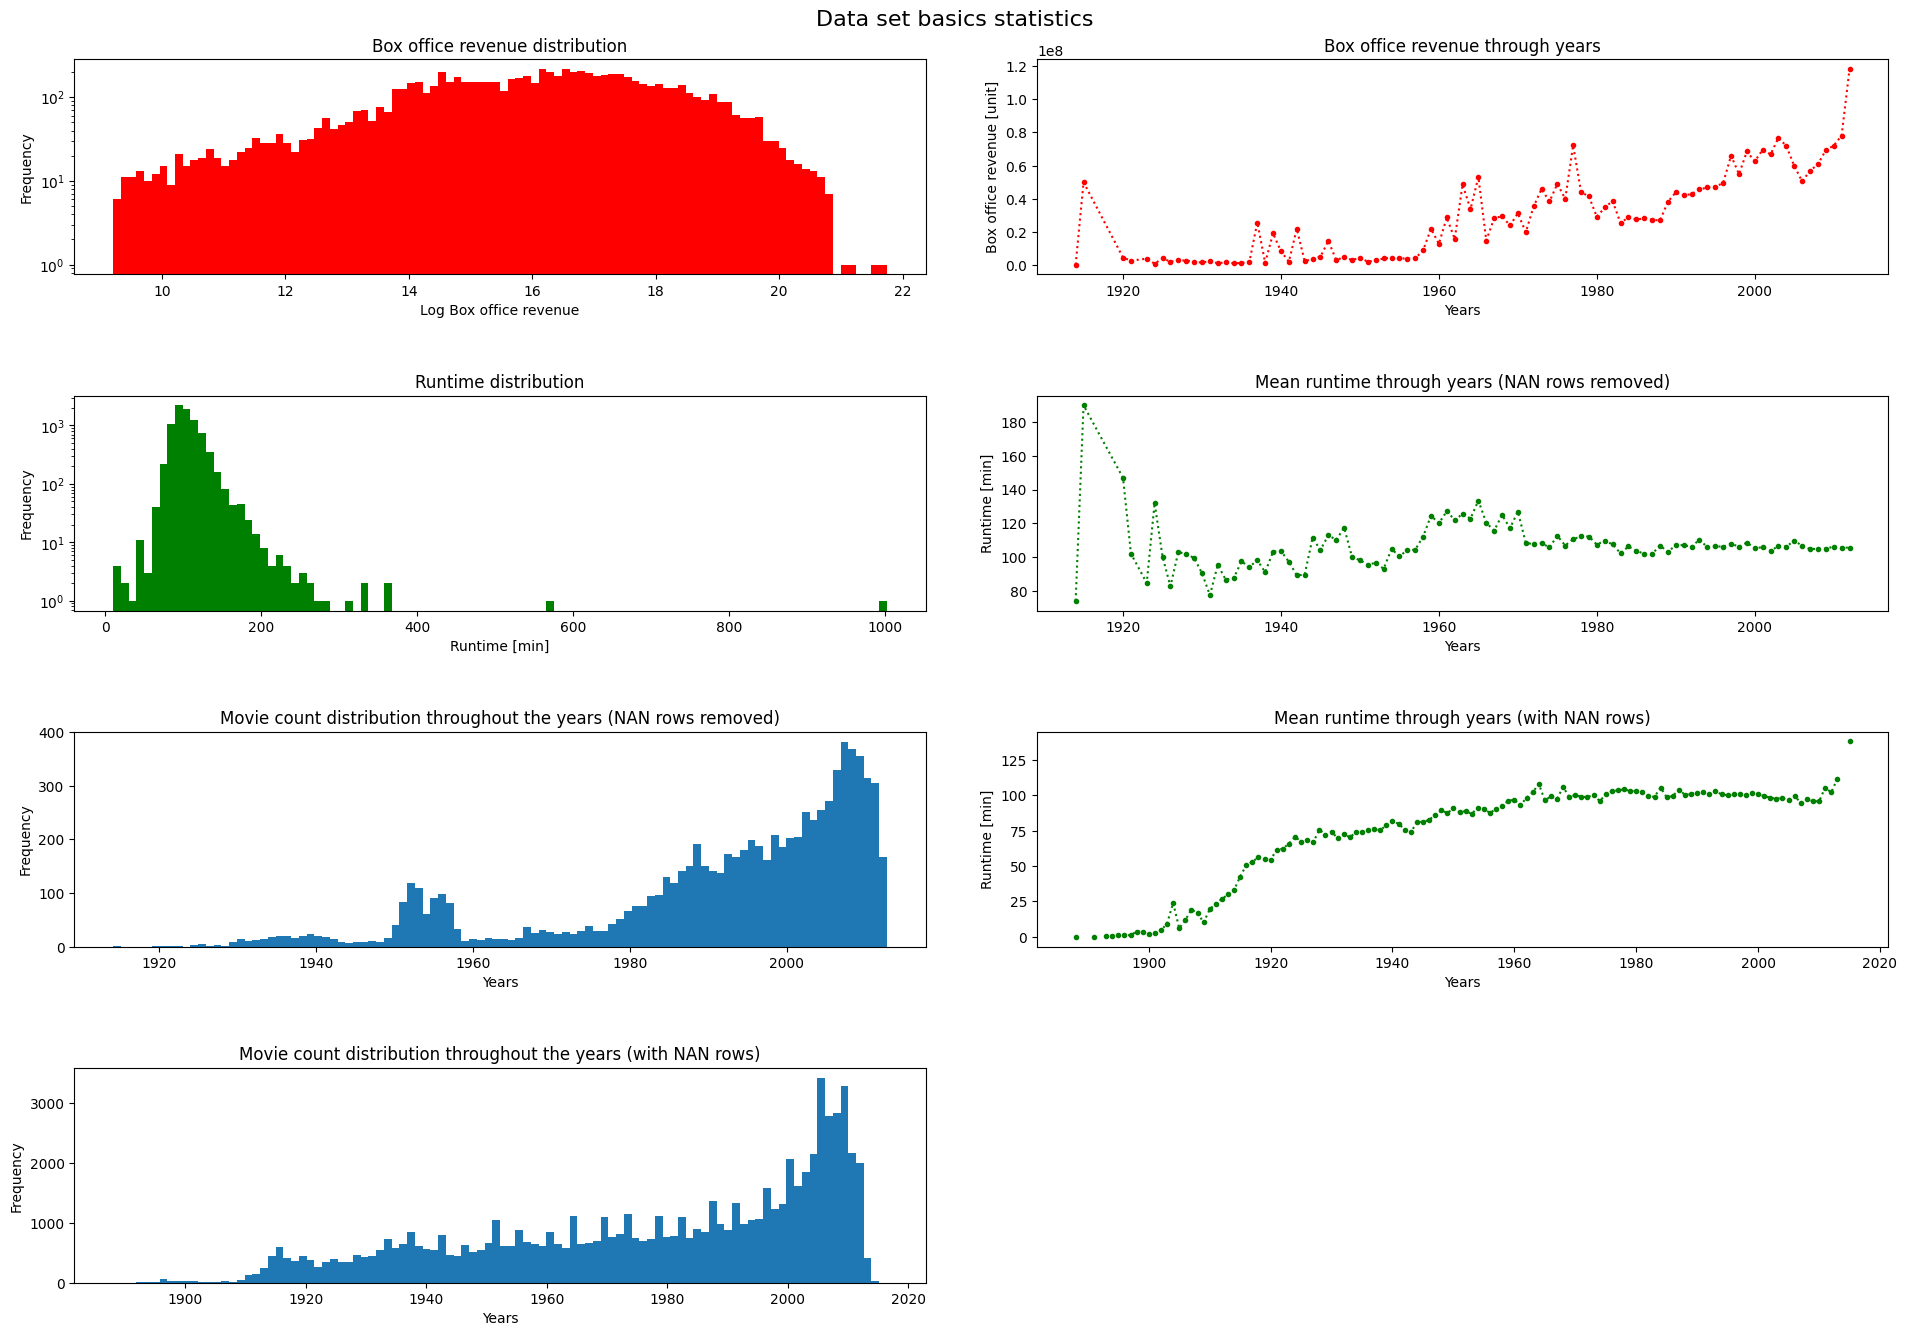

In [722]:
movies_dNA =  movies.dropna().copy()
movies_datetime = movies_dNA.groupby((pd.to_datetime(movies_dNA['Release_date']).dt.to_period('Y'))).apply(lambda x: pd.Series({
    'mean_runtime': x['Runtime'].mean(),
    'mean_box_office_revenue': x['Box_office_revenue'].mean(),
    'num_movies': len(x)
}))

def display_stats(col,name):
    print(f'Statistics for {name}: min: {np.min(col)}, max: {np.max(col)}, median: {np.nanmedian(col)}, mean: {np.mean(col)}, std: {np.std(col)}')

fig, axs = plt.subplots(4, 2)
fig.set_size_inches(20,14)
axs.ravel()[-1].remove()
#fig.tight_layout()

axs[2,0].hist(movies_dNA.Release_date, bins = 100)
axs[2,0].set_ylabel('Frequency')
axs[2,0].set_xlabel('Years')
axs[2,0].set_title('Movie count distribution throughout the years (NAN rows removed)')

axs[3,0].hist(movies.Release_date, bins = 100)
axs[3,0].set_ylabel('Frequency')
axs[3,0].set_xlabel('Years')
axs[3,0].set_title('Movie count distribution throughout the years (with NAN rows)')

axs[0,0].hist(np.log(movies_dNA['Box_office_revenue']), bins = 100,log=True,color = 'r')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_xlabel('Log Box office revenue')
axs[0,0].set_title('Box office revenue distribution')

axs[0,1].plot(movies_datetime.index.to_timestamp(),movies_datetime['mean_box_office_revenue'],'r.:')
axs[0,1].set_ylabel('Box office revenue [unit]')
axs[0,1].set_xlabel('Years')
axs[0,1].set_title('Box office revenue through years')

axs[1,1].plot(movies_datetime.index.to_timestamp(),movies_datetime['mean_runtime'],'g.:')
axs[1,1].set_ylabel('Runtime [min]')
axs[1,1].set_xlabel('Years')
axs[1,1].set_title('Mean runtime through years (NAN rows removed)')

axs[1,0].hist(movies_dNA.Runtime, bins = 100,log=True,color = 'g')
axs[1,0].set_ylabel('Frequency')
axs[1,0].set_xlabel('Runtime [min]')
axs[1,0].set_title('Runtime distribution')


movies_datetimeNA = movies.groupby((pd.to_datetime(movies['Release_date']).dt.to_period('Y'))).apply(lambda x: pd.Series({
    'mean_runtime': x['Runtime'].mean(),
    'mean_box_office_revenue': x['Box_office_revenue'].mean(),
    'num_movies': len(x)
}))
axs[2,1].plot(movies_datetimeNA.index.to_timestamp(),movies_datetimeNA['mean_runtime'],'g.:')
axs[2,1].set_ylabel('Runtime [min]')
axs[2,1].set_xlabel('Years')
axs[2,1].set_title('Mean runtime through years (with NAN rows)')

plt.tight_layout(pad=4)
fig.suptitle('Data set basics statistics', fontsize=16)
#fig.supxlabel('Years')
plt.show()

In [723]:
print(f'By removing all rows containing NaN values, our dataset contains: {len(movies_dNA)} films')
print(f'Movie years of release span from {movies_datetime.index.min()} to {movies_datetime.index.max()}.')
y = np.array(range(1914,2012))
missing_years = y[[str(x) not in movies_datetime.index for x in y]] 
print('Our dataset does not contain films in the years', missing_years)

By removing all rows containing NaN values, our dataset contains: 8243 films
Movie years of release span from 1914 to 2012.
Our dataset does not contain films in the years [1916 1917 1918 1919 1922]


As mentionned earlier, the distributions change significantly if we remove rows containing NaN value. Indeed, a lot of non NaN runtime values are discarded if we decide to remove NaN rows. The same phenomena occurs for the movie distribution through the years. For further analysis in this notebook, we want to keep as much values as possible; so we will try to work with the raw data.

The left column illustrates different features' distributions. The box office revenue (log scale) and the movie count per year are heavy tailed and seemed to be correlated. Nonetheless, with this first plot, we cannot conclude anything yet. 
The movie runtime distribution seems to be more normally distributed (also plotted in log scale). A QQ plot or a boxplot could be fitted to observe to what extent the runtime is gaussian. Some outliers seem to be basic mistakes like being expressed in different units. One movie appears to have a runtime of 1000 minutes ~ 16h which clearly is too big. We could specifically look into these movies but in any case the runtime won't be at the center of our analysis.

The fluctuations in early years comes from the fact that they contain only a few movies and it is therefore difficult to have a stable global tendency.

#### Language and country visualizations

We first replace the blank entries  for the `Countries` and the `Languages` by NaN values to avoid counting them in the visualizations. We also remove the word 'language' in the `Languages`features to set, for exemple, 'German' and 'German language' equivalent.

In [724]:
movies.Countries.replace('', np.nan, regex=False, inplace=True)
movies.Languages.replace('', np.nan, regex=False, inplace=True)
movies.Languages.replace(' language', '', regex=True, inplace=True)

We then remove these NaN values in a copy of the `movies`data to not alter the original one as we previously saw that removing these NaN values for all analysis will limit too much our dataset.

In [725]:
movies_country = movies[movies.Countries.notna()].copy() #remove only the row where Countries contain NaN values
movies_languages = movies[movies.Languages.notna()].copy() #remove only the row where Languages contain NaN values

Creation of a list containing all unique language used in our dataset, here there are 210 of them.

In [726]:
languages_list = []
for languages in movies_languages['Languages']: # languages is a string of languages
    for language in languages.split(', '): # language is a single language
        if language not in languages_list:
            languages_list.append(language) # add language to the list of languages

In [727]:
len(languages_list)

210

We then create a Dataframe containing the number of time a language appeared throughout all movies.

In [728]:
dict_of_lang = {language : [movies_languages['Languages'].apply(lambda x: int(x.count(language))).sum()] for language in languages_list}
Languages_sum = pd.DataFrame.from_dict(dict_of_lang,orient='index', columns=['Sum'])
Languages_sum

,Sum
english,41029
norwegian,208
german,2281
silent film,3183
spanish,3673
...,...
chewa,1
haryanvi,2
assyrian,5
papiamento,1


Text(0.5, 1.0, 'Language distribution')

<Figure size 1000x200 with 0 Axes>

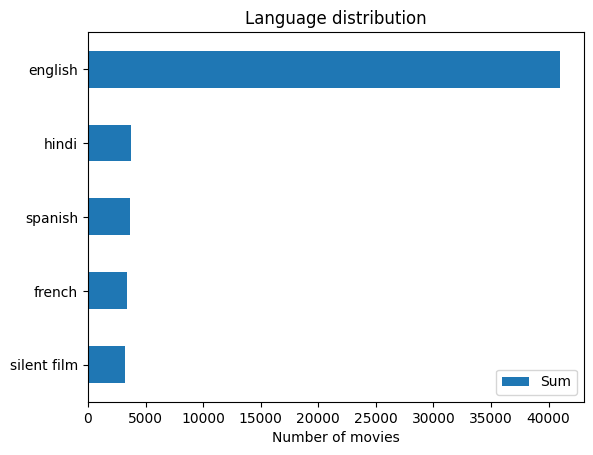

In [729]:
plt.figure(figsize=(10,2))
Languages_sum.sort_values(by='Sum').tail().plot.barh()
plt.xlabel('Number of movies')
plt.title('Language distribution')

Here, we can see the top five languages. English being the global language and the US dominating the movie market, it is not surprising that the english language monopolizes the movie industry. The second language is Hindi which also reflects the importance of the Bollywood industry. Silent films are also predominant as first films do not have sound. 

Creation of a list containing all unique language used in our dataset, here there are 146 of them.

In [730]:
countries_list = []
for countries in movies_country['Countries']: # countries is a string of countries
    for country in countries.split(', '): # country is a single country
        if country not in countries_list:
            countries_list.append(country) # add country to the list of countries

len(countries_list)

146

We then create a Dataframe containing the number of time a country appeared throughout all movies.

In [731]:
dict_of_country = {country : [movies_country['Countries'].apply(lambda x: int(x.count(country))).sum()] for country in countries_list}
Country_sum = pd.DataFrame.from_dict(dict_of_country,orient='index', columns=['Sum'])
Country_sum

,Sum
united states of america,34408
norway,345
united kingdom,7868
germany,3063
south africa,200
...,...
malayalam language,2
macau,1
cyprus,5
german language,1


Text(0.5, 1.0, 'Country distribution')

<Figure size 1000x200 with 0 Axes>

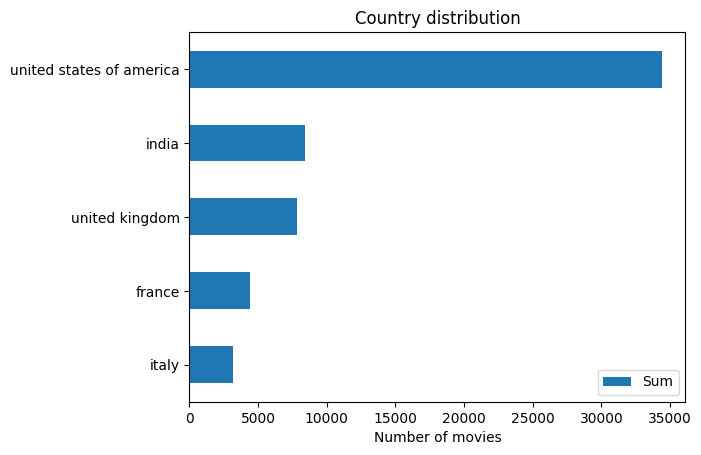

In [732]:
plt.figure(figsize=(10,2))
Country_sum.sort_values(by='Sum').tail().plot.barh()
plt.xlabel('Number of movies')
plt.title('Country distribution')

As expected, the very large majority of movies are from the USA, then most of the rest of movies can be divided into 4 main countries: India, United Kingdom, France and Italy. The other countries are underrepresented compared to these, having released very few movies. Therefore, we will now analyze the `box office revenues` of movies produced in each of these 5 prinicpal countries, since they group most of the movies.

In [733]:
short_countries_list = ['united states of america', 'india', 'united kingdom', 'france', 'italy']

In [734]:
movies_country = movies_country[movies_country.Box_office_revenue.notna()] #remove only the row where Box offcies revenue contain NaN values

In [735]:
for country in short_countries_list:
    movies_country[country] = movies_country['Countries'].apply(lambda x: int(x.count(country)>=1))

In [736]:
Country_Box_office_revenue = movies_country.groupby(pd.to_datetime(movies_country['Release_date']).dt.to_period(freq = 'y')).apply(lambda x:
    #All kind of analysis:
        pd.Series({
            'number': x.count(),
            'mean_US' : x[x['united states of america']>0].Box_office_revenue.mean(),
            'mean_India' : x[x['india']>0].Box_office_revenue.mean(),
            'mean_UK' : x[x['united kingdom']>0].Box_office_revenue.mean(),
            'mean_FR' : x[x['france']>0].Box_office_revenue.mean(),
            'mean_IT' : x[x['italy']>0].Box_office_revenue.mean(),
        }))

Text(0.5, 1.0, 'Box office revenue time evolution by country')

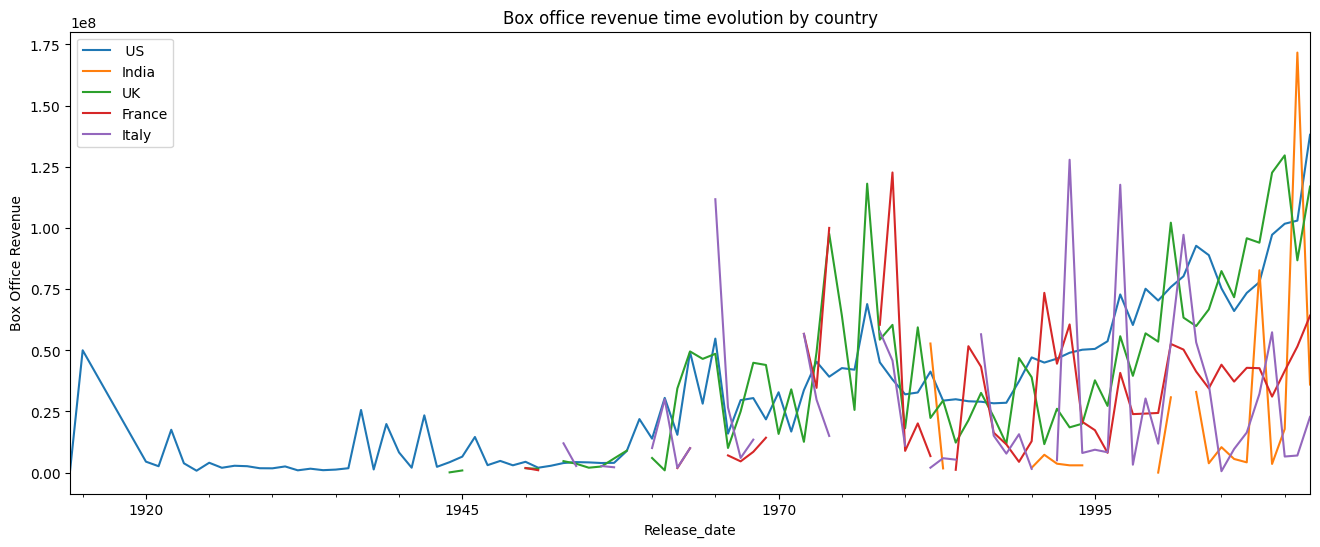

In [737]:
plt.figure(figsize=(16,6))
Country_Box_office_revenue.mean_US.plot(label=" US", legend=True)
Country_Box_office_revenue.mean_India.plot(label="India", legend=True)
Country_Box_office_revenue.mean_UK.plot(label="UK", legend=True)
Country_Box_office_revenue.mean_FR.plot(label="France", legend=True)
Country_Box_office_revenue.mean_IT.plot(label="Italy", legend=True)
plt.ylabel('Box Office Revenue')
plt.title('Box office revenue time evolution by country')
#fig.suptitle('Box Office revenue', fontsize=16)

Here, we can see the evolution of the `Box_office_revenue` for each principal country over time. First, note that there are some holes which correspond to the fact that maybe there was no movies produced or/and movies were removed when one of the information of `Box_office_revenue`or `Countries` was missing. <br>
As shown above, the USA are in the film industry from the begining and they had the monopoly until 1955. Then, Italy and United Kingdom also emerged in the film industry with some up and downs throughout years. <br>
Then, France industry emerged around 1970-1990 competing with the USA industry via successful movies. However, they Box office revenue did not growth as fast as the Hollywood industry since 1995. <br>
Finally, we can see that India is a direct competitor of the USA industry since 2010 which correlates with the explosion of the Bollywood industry. 

### Genre analysis

Let's start by creating a list containing all the genres present in the `movies` dataset. This will allow us to analyze the evolution of genres throughout the years and determine if ceratin historical events are associated to a given genre.

In [738]:
genre_list = []
for genres in movies_plot['Genres']: # genres is a string of genres
    for genre in genres.split(', '): # genre is a single genre
        if genre not in genre_list:
            genre_list.append(genre) # add genre to the list of genres

genre_list = [x.lower() for x in genre_list]

In [739]:
len(genre_list)

364

There are **364** different genres defined in the dataset. Some might be repetitive with each other, it might therefore be possible to group some genres together as done below using the `movies_genres` list. We can also remove the empty, film and short films from the `genre_list`, since they do not represent any concrete genre. 

In [740]:
genre_list.remove('')
genre_list.remove('film')
genre_list.remove('short film')

Now that our genres are defined, we can create a one hot encoding of the presence of a given genre in a movie. If a genre is used to define a movie it will be assigned a value of `1`, if it doesn't describe the movie it will be assigned a `0`.

In [741]:
for genre in genre_list:
    s = {genre : list(movies_plot['Genres'].apply(lambda x: int(x.count(genre)>=1)))}
    movies_plot = pd.concat([movies_plot, pd.DataFrame(data=s)], axis=1)

It can be interesting to determine which movie genre was the most realeased every decade, the popular genres might give informtion about historical events that have influenced the given trends.

In [742]:
fav_genres = movies_plot.groupby(pd.Grouper(key='Release_date',freq='10Y')).apply(lambda x: x.iloc[:,13:].sum(axis=0))
fav_genres

,adventure,supernatural,action,space western,erotic thriller,psychological thriller,drama,family film,fantasy,world cinema,...,buddy picture,journalism,statutory rape,expressionism,finance & investing,new queer cinema,neorealism,the netherlands in world war ii,revisionist fairy tale,homoeroticism
Release_date,,,,,,,,,,,,,,,,,,,,,
1893-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1903-12-31,1,0,0,0,0,0,2,0,4,0,...,0,0,0,0,0,0,0,0,0,0
1913-12-31,2,0,0,0,0,0,39,1,5,1,...,0,0,0,0,0,0,0,0,0,0
1923-12-31,33,1,10,0,0,0,177,17,16,15,...,0,0,0,1,0,0,0,0,0,0
1933-12-31,110,0,82,0,0,6,550,78,25,32,...,0,0,0,1,0,0,0,0,0,0
1943-12-31,288,5,244,0,0,18,839,261,46,30,...,0,0,0,0,0,0,1,0,0,0
1953-12-31,303,4,257,0,0,69,1064,245,75,78,...,0,0,0,0,0,0,0,0,0,0
1963-12-31,396,13,332,0,0,41,1310,228,84,272,...,0,0,0,0,0,0,0,0,0,0
1973-12-31,560,38,534,1,7,75,1401,159,109,438,...,0,0,0,0,0,1,0,0,0,0


In [743]:
maxGenre = fav_genres.max(axis=1)
maxGenre_id = fav_genres.idxmax(axis=1)
maxGenre_id

Release_date
1893-12-31              indie
1903-12-31        silent film
1913-12-31        silent film
1923-12-31        silent film
1933-12-31    black-and-white
1943-12-31    black-and-white
1953-12-31              drama
1963-12-31              drama
1973-12-31              drama
1983-12-31              drama
1993-12-31              drama
2003-12-31              drama
2013-12-31              drama
2023-12-31              drama
dtype: object

From the output above, in the 1890s the most prevalent genre was `indie`. Indie movies are short films produced outside the major filming studios and by independent entertainment companies, therefore their presence in the 1890s marks the begining of film making, when the very first short movies were created. Then, between the 1900s and 1920s, `silent movies` were produced in majority. This also illustrates the film making historical timeline, [Warner Bros](https://www.moma.org/learn/moma_learning/themes/film/experimentation-with-sound/#:~:text=On%20October%206%2C%201927%2C%20Warner,was%20a%20revelation%20for%20audiences.) were the first to syncronise sound recordings to movies in 1927, from this point onwards sound was widely used in movies. Between the 1930s and the 1940s the most released genre was `black-and-white`, which is understandable given that color motion picture films were introduced around 1940 but only came to wide use in 1950, as explained by this [Wikipedia](https://en.wikipedia.org/wiki/Color_motion_picture_film#:~:text=They%20were%20introduced%20around%201940,production%20in%20the%20early%201950s.) article. However, from the 1940s onwards, `drama` is the most popular genre produced, which might reflect the general public's preference, since movies were much more accessible to all from the 1950s onwards due to the television's arrival on the market. The television first, then home videos and later on internet strongly influenced the distribution and consumption of films, as more people watched movies, more movies were made to please the public, which might explain why drama movies were made abundantly.

In [744]:
indie_movies = time_analysis('indie', 0, freq='2y')
silent_movies = time_analysis('silent film', 0, freq='2y')
bw_movies = time_analysis('black-and-white', 0, freq='2y')
drama_movies = time_analysis('drama', 0, freq='2y')

Let's look at the evolution of the presence of these genres with time.

Text(0, 0.5, 'Number of movies (drama scale)')

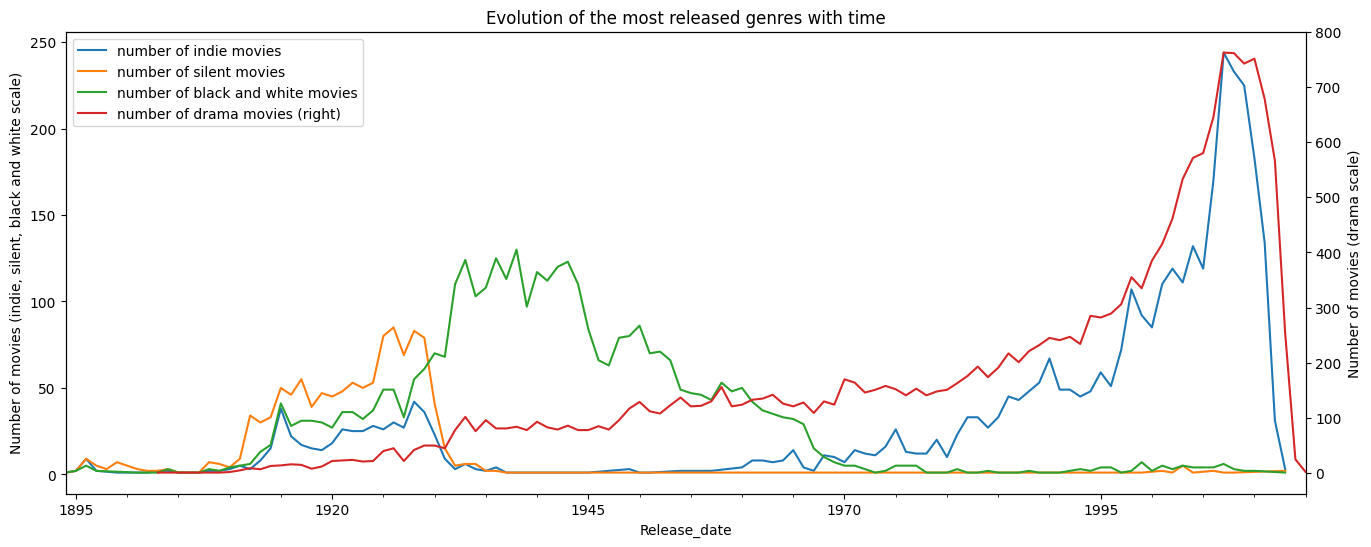

In [745]:
plt.figure(figsize = (16,6))
indie_movies.number.plot(label="number of indie movies", legend=True)
silent_movies.number.plot(label="number of silent movies", legend=True)
bw_movies.number.plot(label="number of black and white movies", legend=True)
plt.ylabel('Number of movies (indie, silent, black and white scale)')
drama_movies.number.plot(secondary_y=True, label="number of drama movies", legend=True)
plt.title('Evolution of the most released genres with time')
plt.ylabel('Number of movies (drama scale)')

The evolution of the number of movies of each genre described above highlights the historical events representing major technological milestones for film making. We can see peaks in each curve that follow each other in chronological order: first a peak in indie and silent movies appear, followed by a peak in black-and-white movies and several years later a very strong increase in drama movies. Indie movies also underwent a significant increase after the 1990s, but this is probably due to stong growth of the movie industry and its productivity overall. 

# STEP 2: Historical dictionnary definitions and applications

Below we define some 'dictionaries'.
These are lists of words that are specific to a historical event. These events are either defined by a finite period of time (e.g. world war) or are movements that appeared at a certain time and then evolved in a continuous manner throughout the years. The aim here is to parse the summary plot of each movie through these dictionaries in order to identify if the movie is related to the event either in his subject or his decorum. With that goal in mind, we chose some events that seem most recognizable in the summaries, using their different lexical fields. <br>
To actually choose the words to put in the dictionaries, we retrieved some lexical fields found on the internet, then aggregated and filtered them to get more specificity. For example 'Tommy' was the nickname of the British soldiers during the two world wars, but it is also the name of some characters throughout that are present in movies that have nothing to do with world wars, thus these types of words were discarded. <br>
To associate a movie with an event we first count the number of occurrences the words in the dictionary occur in a specific plot summary, and we decide to assign the film to the corresponding historical event if the word count is greater than a hand-picked threshold. 

### World War I

In [746]:
WW1 =  ['WW1', 'World War 1', '1914', '1918', 'Allies', 'armistice', 'Central Powers', 'conscription', 'front line', 'Joffre', 'Kaiser', 'Marne',
        'mustard gas', 'no man’s land', 'Pétain', 'u boats', 'Somme', 'Treaty of Versailles', 'trench', 'Verdun', 'Western front', 
        'zeppelin', 'artillery', 'doughboy', 'duckboards', 'dreadnought', 'mobilize', 'Prussia', 'Schlieffen plan', 'Tsar', 'Archduke Ferdinand',
        'Red Baron', 'big four', 'Christmas truce', 'Wilson', 'Lusitania', 'Battalion', 'triple entente', 'Great War', 'flamethrower', 'mills bomb',
        'storm troop', 'ace', 'recco', 'tailspin', 'boche', 'wipers', 'kiwi', 'Aussie', 'cootie', 'Flanders', 'mud', 'war effort', 
        'League of Nations']
WW1 = [x.lower() for x in WW1]

### World War II

In [939]:
WW2 =  ['Allies','Allied','Auschwitz','Bombardment', 'battleship', 'Bailey bridge', 'Blitzkrieg','Churchill','D-Day',
        'Dunkirk', 'Doolittle', 'de Gaulle','English Channel', 'Eisenhower','Enigma','flying tigers', 'free french',
        'nazi','helmet','Hiroshima','Invasion','Luftwaffe','Manhattan Project', 'Midway','Pearl harbor','Normandy', 'Nagasaki',
        'Panzer','Roosevelt', 'Rangers','Resistance','Truman', 'red army','Stalin','soviets', 'tank', 'V-1 rocket','doodlebugs',
        'World War II','ww2','Hitler','air raid','shelter','siren','Battle of Britain','evacuee','evacuation','gas mask',
        'spitfire', '1939', '1945','1940','1941','1942','1943','1944','B-17']
WW2 = [x.lower() for x in WW2]

### Space race

In [748]:
Space = ['aeronautics','Alan Shepard','Apollo','Cape Canaveral','Gemini','heat shields', 
         'Houston','John Glenn','Laika','launch','Lunar Module','Mercury','Michael Collins','Mission Control','NASA','neil Armstrong',
         'orbit','planet','rocket','satellite','Scott Carpenter','Sergei Korolev','solar system','space','space exploration','Space Race',
         'Sputnik','superpowers','test pilot',' USA',' URSS','Yuri Gagarin']
Space = [x.lower() for x in Space]
#'capitalism','Cold War','Communism',

### Technological revolution

In [749]:
Tech = ['Camera', ' CD', 'phone',' Computer',' Disk',' Display', ' car',' Fax',' Fiber optic', ' Laptop',' Laser',' robot',' Printer',' Radio'
        ' Television', 'Photography', 'radioactivity', 'CD-ROM', 'Telephone', 'Telegraph', 'Automobile', 'computer', 'Nuclear power', 'Wireless',
        'Fiber optic', ' Electronics','Bio-tech']
Tech = [x.lower() for x in Tech]

Tech = ['Application', 'Bandwidth','Blog', 'Browser', 'Bugs', 'Bytes',' CAD', ' CAM','Camera', ' CD', 'phone',' Codes', ' Computer',' Copyright', ' Cyberspace',
        ' Data',' Database',' Debug',' Digital', ' Disk',' Display', ' Download',' Drive', ' car',' E-mail', 'Electronic',' Electronics','Bio-tech',' Ethernet'
        ,'FaceBook',' Fax',' Fiber optic',' File',' Geek',' GIF',' net',' Hackers',' Hard disk',' Hard drive',' Hardware', ' Hypertext', ' Informatics', ' Innovation',
        ' Internet',' IPAD',' Joystick',' JPEG',' mail',  'Keyboard','Keypad',' Laptop',' Laser',' robot','Matrix', ' Networks', 
        ' Operating system',' Printer',' Processor',' Program',' Programmer',' Protocol',' Radio',' Satellite',' Scan',' Screen',' Script',' Search engine',
        ' Share','Software',' Spam', 'Statistics',' Technology',' Telecommunication',' Television', 'google','youtube','yahoo','connector',' Upload',' Username',' User-friendly',
        ' Video',' Virus',' Web',' Wireless', ' www','Worldwide web',' weapons',' plane']
Tech = [x.lower() for x in Tech]

### Numerical revolution

In [750]:
Num = ['Application','Blog', 'Browser',' CAD', ' CAM', ' Cyberspace', ' Data',' Database',' Debug',' Digital', ' Disk',
        ' Download',' E-mail' ,' Ethernet' ,'FaceBook',' Fax',' Geek',' net',' Hackers',' Hard disk',' Hardware', ' Informatics',' Internet',
        ' IPAD',' Joystick',' JPEG',' mail',  'Keyboard', 'Keypad',' Laptop', ' Operating system',' Programmer', 'Software',' Spam', 'google',
        'youtube','yahoo', ' Video',' Web', ' www','Worldwide web']
Num = [x.lower() for x in Num]

### Racial segregation

In [751]:
Segregation = ['Racial', 'ethnic groups', 'apartheid', 'Nelson Mandela', 'racial discrimination', 'Jim Crow laws', 'white supremacy', 
               'interracial marriage', 'Rosa Parks', 'Martin Luther King Jr', 'Civil rights', 'Negro', 'discrimination', 'segregation', 'violance',
              'colored districts', 'ku klux klan', 'kkk']
Segregation = [x.lower() for x in Segregation]

### LGBTQ+ emancipation

In [752]:
LGBT = ['Lesbian', 'gay', 'Bisexual', 'transgender', 'gender identity', 'non-cisgender', 'queer', 'Gender variance', 'homosexuality', 
        'Gay liberation', 'Stereotype', 'AIDS stigma', 'feminism', 'gay rights', 'Daughters of Bilitis', 'patriarchal', 'marginalize', ]
LGBT = [x.lower() for x in LGBT]

### Rock'n Roll

In [753]:
Rock = ['Rock and roll', 'jazz', 'rhythm', 'saxophone', 'electric guitars', 'Boswell Sisters', 'Rosette', 'gramophone', 'swing',
        'race music', 'Elvis Presley', 'Johnyy Cash', 'music', 'musician', 'singer', ' band', 'album', 'vinyl', 'rock star', 'music award','sing', 'tour']
Rock = [x.lower() for x in Rock]

### AIDS

In [754]:
AIDS = ['HIV', 'AIDS', 'immunodeficiency', 'infection', 'retrovirus', 'contaminated', 'skin cancer', 'homosexual men', 'discrimination', 
        'protection', 'anti-homosexual', 'Freddie Mercury', 'epidemic', 'diagnosed']
AIDS = [x.lower() for x in AIDS]

### Nuclear

In [755]:
Nuclear = ['atom bomb', 'A-Bomb', 'nuclear', 'mass destruction', 'explosive', 'TNT', 'radiation', 'Hiroshima','nagasaki', 'uranium', 
           'fission bomb', 'radioactive', 'plutonium', 'thermonuclear', 'gamma rays', 'X-rays', 'isotopes', 'gravity bomb', 'missiles']
Nuclear = [x.lower() for x in Nuclear]

### Comics

In [756]:
Comics = ['Superman', 'supervillains', 'superhero', 'hero', 'Kryptonite', 'Clark Kent', 'Gotham', 'Warner Bros', 'Walt Disney',
          'Mickey Mouse', 'Donald Duck', 'Technicolor', 'Batman', 'super power', 'Marvel', 'DC', 'Wonder woman', 'Thor', 
          'catwoman', 'Batsuit', 'Batmobile', 'Shadow', 'Dick Tracy', 'Flash Gordon', 'teleportation', 'justice', 'Super evil', 'cartoons',
          'fight evil', 'masked', 'iron man']
Comics = [x.lower() for x in Comics]

### Twin Towers

In [757]:
Towers = ['September 11 attacks', 'twin towers', ' World Trade Center','WTC', 'terrorist ', 'Al-Qaeda', 'hijackers', 'Boeing 767', 'Destruction', 
          'American Airlines Flight 11', ' Osama bin Laden',  ]
Towers = [x.lower() for x in Towers]

### Format

To optimize handling of the dictionnaries we create a dataframe `dictionnaries` that contains the list of words for each event and the threshold associated to it.

In [940]:
events = {'words_list': [WW1,WW2,Space,Tech,Num,Segregation,LGBT,Rock,AIDS,Nuclear,Comics,Towers]}
dictionnaries = pd.DataFrame(data=events, index=['WW1','WW2','Space','Tech', 'Num', 'Segregation','LGBT', 'Rock', 'AIDS', 'Nuclear', 'Comics', 'Towers'])

In [941]:
dictionnaries

,words_list
WW1,"[ww1, world war 1, 1914, 1918, allies, armisti..."
WW2,"[allies, allied, auschwitz, bombardment, battl..."
Space,"[aeronautics, alan shepard, apollo, cape canav..."
Tech,"[camera, cd, phone, computer, disk, displa..."
Num,"[application, blog, browser, cad, cam, cybe..."
Segregation,"[racial, ethnic groups, apartheid, nelson mand..."
LGBT,"[lesbian, gay, bisexual, transgender, gender i..."
Rock,"[rock and roll, jazz, rhythm, saxophone, elect..."
AIDS,"[hiv, aids, immunodeficiency, infection, retro..."
Nuclear,"[atom bomb, a-bomb, nuclear, mass destruction,..."


### Metric

As mentioned in the methods section of the README, we still need to define the right way to use these engineered features. For the moment, we decided to assign by hand thresholds that seem intuitively correct for each historical event. In fact, we clearly see the influence of the specificity of the dictionary on the created features. For instance, the tech dictionary is quite general thus needs a high threshold to not include every movie. While the Segregation dictionary is not very sensitive; a single word matching is enough to be confident that the movie is truly talking about segregation, since the topic is described by quite a unique vocabulary. However, we might miss movies. That is a trade-off between specificity and sensitivity. 

We want to take into account the size of our dictionnaries. When the dictionnary is big, more words can be identified in each summary, leading to more summaries classified as the corresponding historical event. To avoid this bias, we want to penalize summaries associated to bigger dictionnaries. These will need to reach a bigger threshold to be retained in its category for further analysis. To do so, we perform a min-max normalization of the length of dictionnaries, norms are in [1,2] with 1 corresponding to the smallest dictionnary and 2 to the larger dictionnary. These norms are then used a weights for the thresholds. A higher norm will induce a higher threshold. 

In [942]:
def get_minmax(_lists):
    """
    Parameters
    ----------
    _lists : a pd.Series containing all lists of words describing an historical event
    
    Returns
    -------
    The lengths of both the smallest and largest lists
    """
    lengths = [len(l) for l in _lists]
    return min(lengths),max(lengths)

In [943]:
def minmax_norm(length, minimum, maximum):
    """
    Parameters
    ----------
    length : the length of a list of words
    minimum : the minimum length among all lists of words
    maximum : the maximum length among all lists of words
        
    Returns
    -------
    min-max normalization of length scaled between [1,2]
    """
    return ((length - minimum) / (maximum - minimum)) + 1

In [944]:
def get_thresholds(dictionnaries, baseline=0.005):
    """
    Parameters
    ----------
    dictionnaries : pd.DataFrame that contains each historical event associated to its list of words.
    baseline : threshold baseline
        
    Returns
    -------
    A simple dict object which key is 'threshold' and value is the list of thresholds for each historical event 
    """
    minimum, maximum = get_minmax(dictionnaries.words_list)
    return {'threshold' : list(dictionnaries.words_list.apply(lambda x : baseline*minmax_norm(len(x),minimum,maximum)))}

In [945]:
#add the thresholds to the dictionnaries dataframe
dictionnaries = pd.concat([dictionnaries,pd.DataFrame(data=get_thresholds(dictionnaries),index=dictionnaries.index)], axis=1)
dictionnaries

,words_list,threshold
WW1,"[ww1, world war 1, 1914, 1918, allies, armisti...",0.009674
WW2,"[allies, allied, auschwitz, bombardment, battl...",0.010000
Space,"[aeronautics, alan shepard, apollo, cape canav...",0.007283
Tech,"[camera, cd, phone, computer, disk, displa...",0.006630
Num,"[application, blog, browser, cad, cam, cybe...",0.008261
Segregation,"[racial, ethnic groups, apartheid, nelson mand...",0.005761
LGBT,"[lesbian, gay, bisexual, transgender, gender i...",0.005652
Rock,"[rock and roll, jazz, rhythm, saxophone, elect...",0.006196
AIDS,"[hiv, aids, immunodeficiency, infection, retro...",0.005326
Nuclear,"[atom bomb, a-bomb, nuclear, mass destruction,...",0.005870


### Dictionnary applications and metrics

For consistency, we will apply lower case to every plot summary:

In [946]:
summaries = movies_plot.Summary.apply(lambda h: h.lower())

We can create a first feature containing the count of the number of times a word from a given dictionnary appears in a plot summary. This function creates a new column in the movies_plot DF.

To account for the length of the plot summary, we normalize the counts by dividing by the number of words in the plot. Thus the new features contain the proportion of words 

In [947]:
def word_count(text):
    """
    Parameters
    ----------
    text : a string with words and white spaces
        
    Returns
    -------
    The number of words in text (white spaces not included)
    """
    return len(text.strip().split(" "))

In [948]:
movies_plot['Token'] = movies_plot.Summary.apply(lambda h: h.lower().strip().split(" "))

In [949]:
movies_plot.Token

0        [set, in, the, second, half, of, the, 22nd, ce...
1        [a, series, of, murders, of, rich, young, wome...
2        [eva,, an, upper, class, housewife,, becomes, ...
3        [every, hundred, years,, the, evil, morgana, ,...
4        [adam,, a, san, francisco-based, artist, who, ...
                               ...                        
42199    [{{plot}}, the, film, opens, with, a, great, w...
42200    [two, former, national, oceanic, atmospheric, ...
42201    [{{no, plot}}, this, film, follows, 12, years,...
42202    [the, story, takes, place, in, the, year, 2092...
42203    [the, movie, is, about, a, teenage, girl, who,...
Name: Token, Length: 42204, dtype: object

In [950]:
def count_dict(name, dictionnary):
    """
    Parameters
    ----------
    name : name of the column to add to movies_plot i.e. the name of a historical event
    dictionnary : list of words describing a historical event
        
    Returns
    -------
    Nothing. Add a new column to `movies_plot` containing for each summary the proportion of words that are also present in dictionnary.
    """
    #movies_plot[name] = summaries.apply(lambda summary: np.sum([summary.count(word) for word in dictionnary])/word_count(summary))
    
    movies_plot[name] = movies_plot.Token.apply(lambda summary : np.sum([summary.count(word) for word in dictionnary])/len(summary))


In [951]:
#add the proportion of words describing each historical event for each summary.
dictionnaries.index.to_series().apply(lambda i : count_dict(i,dictionnaries.loc[i].words_list));

In [952]:
#check last columns
movies_plot.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres,Summary,...,Space,Tech,Num,Segregation,LGBT,Rock,AIDS,Nuclear,Comics,Towers
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,english language,united states of america,"thriller, science fiction, horror, adventure, ...","Set in the second half of the 22nd century, th...",...,0.002786,0.0,0.0,0.0,0.0,0.0,0.0,0.002786,0.0,0.0


### WordCount Plots

To get a first sense of if the dictionnaries implemented previously accurately sort the `movies_plot` dataset into their respective historical periods or events, we will use a data visualization technique used for representing the frequency of words in text data: `WordCloud` plots. Word clouds highlight significant textual data points through plots in which the size of each word indicates its frequency or importance. We will therefore create WordCloud plots of the summaries of the movies that were historically sorted using the dictionnaries defining events. This will allow us to determine if the most frequent words in the summaries match the words that build the respective dictionnaries used.

In [924]:
def get_event_features(event,features):
    """
    Parameters
    ----------
    event : column name of a historical event
    features : list of features to return
        
    Returns
    -------
    Return features of movies that are associated to a particular event.
    """
    return movies_plot[movies_plot[event] > dictionnaries.loc[event].threshold][features]

In [925]:
# First separate the movies by historical event and keep only the summaries
# keys of movies_event are the events' name and their value is a dataframe containing all summaries related to this key
movies_event = {}
dictionnaries.index.to_series().apply(lambda i : movies_event.update({i : get_event_features(i,['Summary'])}));

In [926]:
# Check for null values since WordCount doesn't accept text with NAN
for d in movies_event.values() :
    print(d.isna().sum())

Summary    0
dtype: int64
Summary    0
dtype: int64
Summary    0
dtype: int64
Summary    0
dtype: int64
Summary    0
dtype: int64
Summary    0
dtype: int64
Summary    0
dtype: int64
Summary    0
dtype: int64
Summary    0
dtype: int64
Summary    0
dtype: int64
Summary    0
dtype: int64
Summary    0
dtype: int64


In [927]:
#Setup the environment to generate word clouds
w = WordCloud()
stop_words = list(w.stopwords) # remove usual stop words (frequently used)
custom_stop_words = ['find', 'back', 'one', 'will', 'take', 'film'] # remove other meaningless frequent words
stop_words = set(stop_words + custom_stop_words)

# Generate word clouds
def gen_word_clouds(event):
    """
    Parameters
    ----------
    event : column name of a historical event
        
    Returns
    -------
    Return a WorldCloud object computed on all summaries classified a part of event.
    """
    # get the summaries classified in event and join them because WordCloud only accepts strings
    v = " ".join(text for text in get_event_features(event,['Summary']).Summary) 
    return WordCloud(collocations = False, background_color = 'white', stopwords=stop_words).generate(v)

In [ ]:
# Plot word clouds
fig, axs = plt.subplots(4, 3, figsize=(20,15))
axravel = axs.ravel()
for i,event in enumerate(dictionnaries.index):
    axravel[i].imshow(gen_word_clouds(event), interpolation="bilinear")
    axravel[i].set_title(f"{event} vocabulary")
    axravel[i].axis('off')

The word clouds above show very promising results. All the movie categories show frequent words explicitely relating to the historical period they were assigned to. For example, in the `WWII` word cloud, the word **german** appears frequently in the movie summaries even though it was not used to build the WWII dictionnary. This is also the case for the word **Earth** or **alien** in the `SpaceRace` movie dataframe. The example is also found in the `Segregation` and `LGBT` dataframes, which respectively see the words **black**, **white** and **friend**, **Family** or **father** (relating to gay coming out) appear in the word cloud plots but not in their dictionnaries. 

For the `Rock` word cloud, we can see that we only find dictonnary's words and other are more general words. This could indicate that either our dictionnary is not well defined or our data does not contain main Rock movies. 

In contast, `AIDS`, `Nuclear`, `Comics` and `Towers` word clouds output words that are not present in the dictionnaries like **Shiva**, **father** for `AIDS`, **President**, **Sovier** and **American** for `Nuclear`, **power**, **evil** and **criminal** for `Comics` and lastly, **destruction** and **passager** for `Towers`.

Finally in the `WWI` word cloud, the name **Grace** abundantly appears and does not in the dictionnary. [Grace Banker](https://en.wikipedia.org/wiki/Grace_Banker) was a telephone operator who served during WWI as chief operator of mobile for the American Expeditionary Forces (AEF) in the U.S. Army Signal Corps. 

So, these word coulds can verify our dictionnaries and give us more information about movies set to a dictionnary.

# Performance analysis on our distionnary search

First, we create a Dataframe with movies as rows, with their summary and a categorical variable assigning them to an event we defined earlier 

In [1111]:
#create dataframe with all movies containing their respective category and summary
data_NLP = movies_plot.copy()
for event in (dictionnaries.index.to_series()):
    data_NLP[event] = movies_plot[event] > dictionnaries.loc[event].threshold
    data_NLP[event] = data_NLP[event].apply(lambda x : int(x))

In [1112]:
data_NLP.head()
data_NLP.shape

(42204, 384)

To analyse the achieved performance of our technique to identify movies talking about a historical event, we need to define a test set. The test set has been defined by one of the group member by simply labelling by hand the movie.

For simplicity, only one event has been analysied: WW2. The problem is now simply to label (assign a class label) the movies is a WW2 movie or not based on all the information we have: essentially the whole data frame data_for_labeling (movies_plot without dict. scores). We also assume that movies are ordered randomly in this dataframe and thus label a subset of movies from the start of the dataframe. 

In [1113]:
y_test = np.zeros(150)
y_test[42],y_test[65],y_test[115],y_test[118],y_test[121] = 1,1,1,1,1 #if miss handled, can directly manually label like this
len(y_test)

150

In [1114]:
y_pred_WW2 = data_NLP.iloc[:150].WW2
len(y_pred_WW2)

150

In [1117]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Accuracy :',np.sum(y_test == y_pred_WW2)/len(y_test))
print('number of bad pred : ',np.sum(y_test != y_pred_WW2))
print('f1 score :',f1_score(y_test, y_pred_WW2))
id_bad = y_test != y_pred_WW2
print('Id of bad prediction: ',id_bad[id_bad==True])
#print('predictor fails :',y_test[id_bad],y_pred_WW2[id_bad])
#print(y_pred_WW2[y_pred_WW2 == True])

Accuracy : 0.9933333333333333
number of bad pred :  1
f1 score : 0.888888888888889
Id of bad prediction:  42    True
Name: WW2, dtype: bool


In [1118]:
scores = movies_plot.iloc[:150].Token.apply(lambda summary : np.sum([summary.count(word) for word in dictionnaries.words_list.loc['WW2']])/len(summary))
def WW2_performance(tresh):
    return scores > tresh

In [1122]:
#to disable warnings
import warnings
warnings.filterwarnings("ignore")

precision = []
recall = []
f1 = []
tresholds = np.logspace(-4,-1,num = 500)
for tresh in tresholds:
    pred = WW2_performance(tresh)
    #print(pred)
    prec = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    if rec != 0 or prec != 0: 
        precision.append(prec)
        recall.append(rec)
        f1.append([tresh,f1_score(y_test, pred)])

best f1 score is 0.888888888888889 with treshold 0.009908136566858666


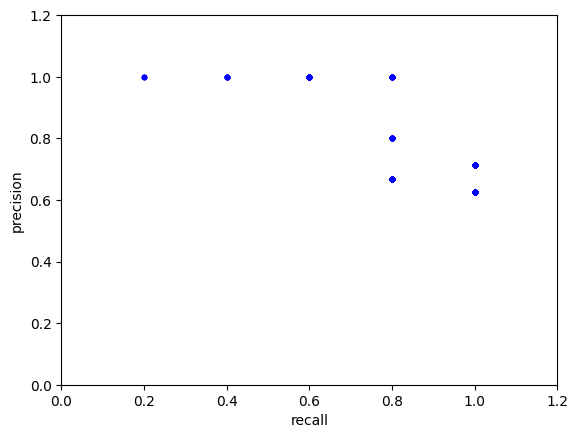

In [1123]:
plt.plot(recall,precision,'b.')
plt.xlabel('recall')
plt.ylabel('precision')
plt.xlim([0,1.2])
plt.ylim([0,1.2])

print(f'best f1 score is {np.max(np.array(f1)[:,1])} with treshold {f1[np.argmax(np.array(f1)[:,1])][0]}')

This anaylsis shows that our classifier is pretty good. We can note that in general our classifier yields good precision (from the above curve), meaning that we can trust our method when it predicts something true. But, it might miss some movies. 

However, by labelling the data, sometime even for a human it is our decision to choose if the movie is talking about WW2 or not. For instance two case where it is ambiguous are the ids 42 and 118 displayed below. For the 118 situation, our classifier will easily label it WW2 movie because there is a high concentration of words linked to. But we might say the opposite as the movie is not really on WW2 but rather talking about people linked to it. So what to choose ? It is an edge case. 

The same situation can be told for the id 42. The movie is not really about WW2, but some scene take place in it and also some people are linked to it. Our classifier has difficulties to label it as WW2 because plot summary is not so specific about it. 

To wrap up, the classification task here happens in a very unbalanced dataset. So, small errors can induce big change in the metrics such as F1 score etc... To be more precise about assessing our method, a lot of movies would have to be hand labelled. Also, this approach could be used to asses the performances of our method on the other events we defined.

In [1124]:
print('id 18 :',data_NLP.Summary.iloc[118])
print('id 42 :',data_NLP.Summary.iloc[42])

id 18 : An American Intelligence Agent and Nazi hunter is on the trail of a former SS war criminal reminiscent of Martin Bormannhttp://movies.nytimes.com/movie/review?res=9902EFD7163FE03ABC4851DFB4678383659EDE believed to be hiding in the French Foreign Legion in Indochina.
id 42 : The film opens in 1991, with the funeral of a World War II veteran. The man's daughter Marie  delivers the eulogy to a church full of veterans who knew and loved her father, while her mother Ethel Ann  is sitting out on the church porch, smoking and nursing a hangover. When Ethel Ann begins acting strangely, only her friend Jack  seems to understand why. It quickly emerges that there is a lot Marie does not know about her mother's past and the true story of her love life. The movie flips to a time when this mother was young, lively, and optimistic . She is in love with a young farmer, Teddy Gordon , who goes off to war with his best friends Jack ([[Gregory Smith  and Chuck , but not all of them make it back 

# Similarity analysis of the newly created categories:

Let's now analyse how these summaries are related through NLP analysis. The first and simplest approach we will use is to analysis the plot summaries through the TF-IDF matrix.

In [1125]:
from sklearn.feature_extraction.text import TfidfVectorizer


To capture how different they are from eachother, we will contruct the TFIDF matrix only from summaries included in one of the category

In [1126]:
#remove film assigned to any categories/event
ids = np.sum(np.array(data_NLP[dictionnaries.index.to_series()]),axis = 1)
ids = [x>=1 for x in ids]
data_NLP = data_NLP.iloc[ids]

In [1127]:
#verify
print(len(data_NLP[np.sum(data_NLP[dictionnaries.index.to_series()],axis = 1) < 1]))
print('Length of classified movies : ',len(data_NLP))


0
Length of classified movies :  3795


In [1128]:
print(f'There are {len(data_NLP[np.sum(data_NLP[dictionnaries.index.to_series()],axis = 1) > 1])} movies in several categorical event')

There are 246 movies in several categorical event


For simplicity, let's remove movies categorized in several event.

In [1129]:
data_NLP = data_NLP[np.sum(data_NLP[dictionnaries.index.to_series()],axis = 1) == 1]
len(data_NLP)

3549

Let us create a custom label per historical event for future purpose: 

In [1170]:
temporary_matrix = np.array(data_NLP[dictionnaries.index.to_series()])
custom_label = [0]*len(data_NLP)
for i in range(len(data_NLP)):
    custom_label[i] = list(temporary_matrix[i]).index(1)
    
data_NLP['label'] = custom_label

Now let's treat the summaries with current NLP techniques reducing the sparcity of the TFIDF matrix

In [1131]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def clean(text):
    
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text)
    
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    
    # remove whitespaces 
    text = ' '.join(text.split())
    
    # convert text to lowercase 
    text = text.lower() 
    
    # remove stopwords
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    text = ' '.join(no_stopword_text)
    
    return text

data_NLP['clean_plot'] = data_NLP['Summary'].apply(lambda x : clean(x))

Now let's compute the TFIDF:

In [1132]:
vectorizer = TfidfVectorizer()
TFIDF = vectorizer.fit_transform(data_NLP.clean_plot)
TFIDF.shape

(3549, 37869)

Let's factorize the TFIDF for compression and visualization purpose:

In [1133]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000, n_iter=10, random_state=42) #slide 52, 53 etc
projected_summaries = svd.fit_transform(TFIDF)
projected_summaries.shape

(3549, 1000)

In [1166]:
def plot_categories(data,categories):
    """
    Parameters
    ----------
    data : matrix containing the data points: (N,M) where N is the number of datapoint and M the number of features
    kmeans : kmean object performed on projected_features
    
    Returns
    -------
    This function helps to visulualize clusters performed on high dimensionnal dataset. 
    Specifically, if the data is ordered in feature importance (PCA for ex), the function will plot the data projected onto the two first features
    (also already projected onto a lower dimensionnal space).
    
    """
    
    plt.scatter(data[:, 0], data[:, 1],c = categories,s= 10,alpha=0.3,label=categories)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    

In [1171]:
event_name = []
for n in dictionnaries.index.to_series():
    event_name.append(n)

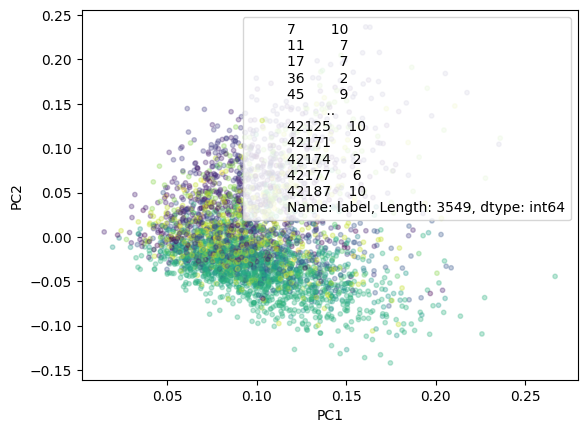

In [1168]:
plot_categories(projected_summaries,data_NLP.label)

Apparently, all summaries of event are not so different in the two fist PC. Let us try to see in average what are the differences between class. We thus compute the mean projected vectorfor each event:

In [1172]:
n_event = len(dictionnaries.index.to_series())
mean_projecton_per_event = [np.zeros_like(projected_summaries[0])]*n_event
event = []
for c in range(n_event):
    event.append(c)
    mean_projecton_per_event[c] = np.mean(projected_summaries[data_NLP.label == c],axis = 0)
    
n_event = len(dictionnaries.index.to_series())
mean_projecton_per_event_notCompressed = [np.zeros_like(TFIDF[0])]*n_event
event = []
for c in range(n_event):
    event.append(c)
    mean_projecton_per_event_notCompressed[c] = np.mean(TFIDF[data_NLP.label == c],axis = 0)

In [1173]:
mean_projecton_per_event_notCompressed = np.reshape(mean_projecton_per_event_notCompressed,[12,TFIDF.shape[1]])
np.array(mean_projecton_per_event_notCompressed).shape

(12, 37869)

In [1174]:
np.array(mean_projecton_per_event)[:, 0].shape

(12,)

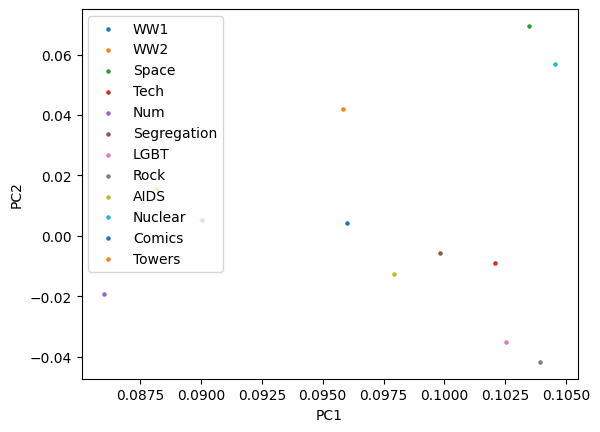

In [1180]:
#add legend !!
for c in range(n_event):
    plt.scatter(np.array(mean_projecton_per_event)[c, 0], np.array(mean_projecton_per_event)[c, 1],s= 5,label=event_name[c])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

Let's also compute the cosine distance between all of them:

In [1091]:
#mean_projecton_per_event

In [1092]:
#build heatmap
from scipy.spatial import distance

def cosine_matrix(mean_projecton_per_event,n_event):
    event_cosine = []
    for i in range(n_event):
        temp = []
        for j in range(n_event):
            temp.append(distance.cosine(mean_projecton_per_event[i][:],mean_projecton_per_event[j][:]))
        event_cosine.append(temp) 
    return event_cosine

In [1093]:
event_cosine = cosine_matrix(mean_projecton_per_event,n_event)
event_cosine_notCompr = cosine_matrix(mean_projecton_per_event_notCompressed,n_event)

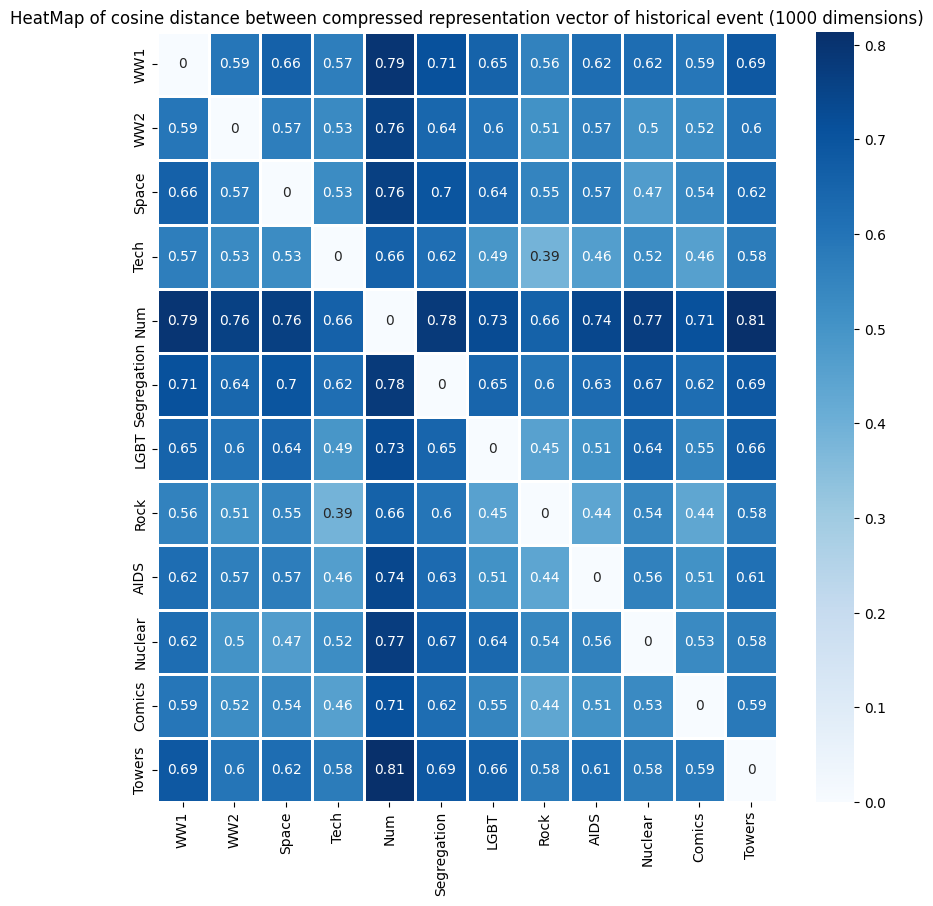

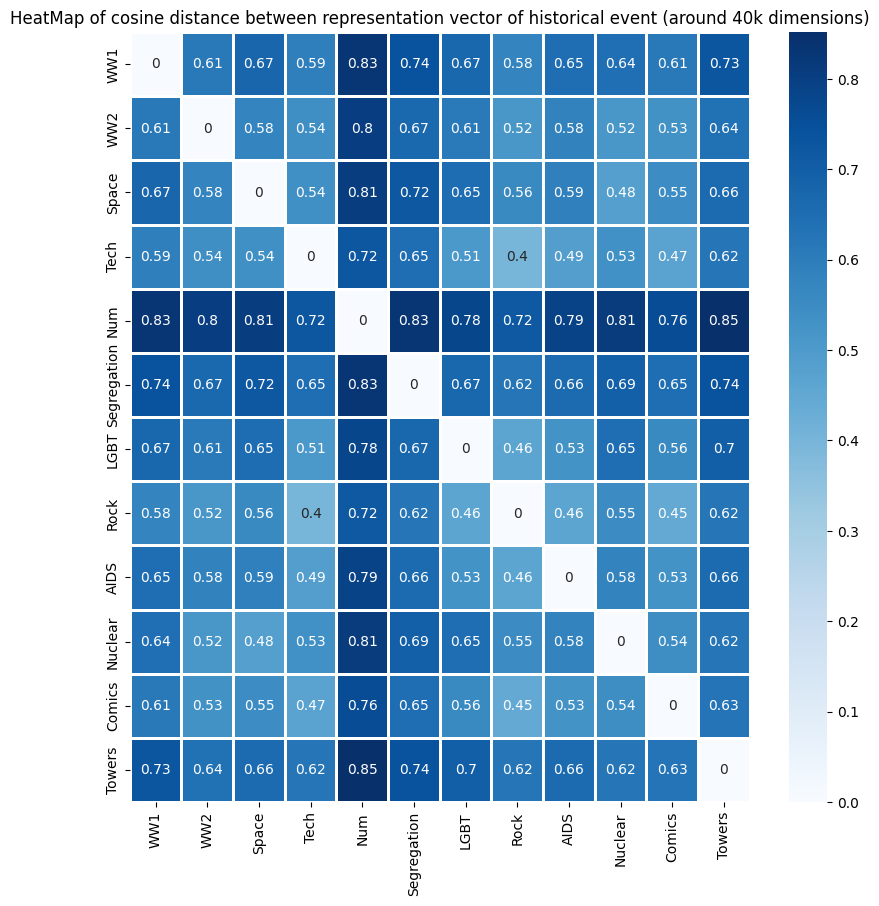

In [1096]:
plt.figure(figsize=(10,10))
heat_map = sns.heatmap(event_cosine, linewidth = 1 , annot = True,xticklabels=event_name, yticklabels=event_name,cmap="Blues")
plt.title( "HeatMap of cosine distance between compressed representation vector of historical event (1000 dimensions)" )
plt.show()

plt.figure(figsize=(10,10))
heat_map = sns.heatmap(event_cosine_notCompr, linewidth = 1 , annot = True,xticklabels=event_name, yticklabels=event_name,cmap="Blues")
plt.title( "HeatMap of cosine distance between representation vector of historical event (around 40k dimensions)" )
plt.show()

# STEP 3: Examples of historical event characterisations


### Which genres are used to convey a historical event ?

We can now analyze genre appearance for our historical periods and the evolution of the number of movies narrating the historical events with time.

We narrowed down the 364 genres to a list of more specific and useful ones for the heatmap plot below. Certain genres were grouped together into to broader categories to avoid repitition and very niche categories were omitted.

In [107]:
movies_genres = ['Action', 'Adventure', 'Comedy', 'Fantasy', 'Historical', 'Horror', 'Satire', 'Speculative',
                 'Thriller', 'Western', 'Drama', 'Documentary', 'Musical', 'Romance','Mystery', 'War', 'Biography', 'History',
                 'zombie film', 'Alien', 'anti-war', 'Black-and-white', 'Cold war', 'combat', 'Conspiration', 'crime', 'Erotic', 
                 'Gay', 'LGBT', 'Political', 'sci-fi', 'children']
movies_genres = [x.lower() for x in movies_genres]

In [108]:
#add one_hot encoder genre columns to movies_plot
for genre in movies_genres:
    movies_plot[genre] = movies_plot['Genres'].apply(lambda x: int(x.count(genre)>=1)) 

In [109]:
#get the proportions of genres for movies for each event
dictionnary_genres = pd.DataFrame()
for event in dictionnaries.index:
    count_pergenre = get_event_features(event,movies_genres).sum() #sum number of each genre perdictionnary
    dictionnary_genres[event] = 100*count_pergenre / count_pergenre.sum() 
dictionnary_genres.head()

,WW1,WW2,Space,Tech,Num,Segregation,LGBT,Rock,AIDS,Nuclear,Comics,Towers
action,9.818182,10.152284,13.487738,7.407407,6.122449,5.696203,1.173709,3.194103,5.348837,17.331288,15.839493,11.258278
adventure,8.000000,6.598985,18.119891,6.509540,2.040816,3.797468,1.173709,2.211302,4.418605,12.883436,12.988384,8.609272
comedy,16.363636,8.223350,13.896458,16.386083,16.326531,5.696203,17.018779,18.427518,8.837209,6.901840,12.143611,9.271523
fantasy,1.454545,1.015228,5.313351,1.907969,0.000000,1.898734,1.291080,1.031941,1.860465,2.914110,3.801478,3.311258
historical,1.818182,1.319797,0.136240,0.336700,2.040816,1.898734,0.000000,0.393120,0.697674,0.153374,0.316790,1.324503


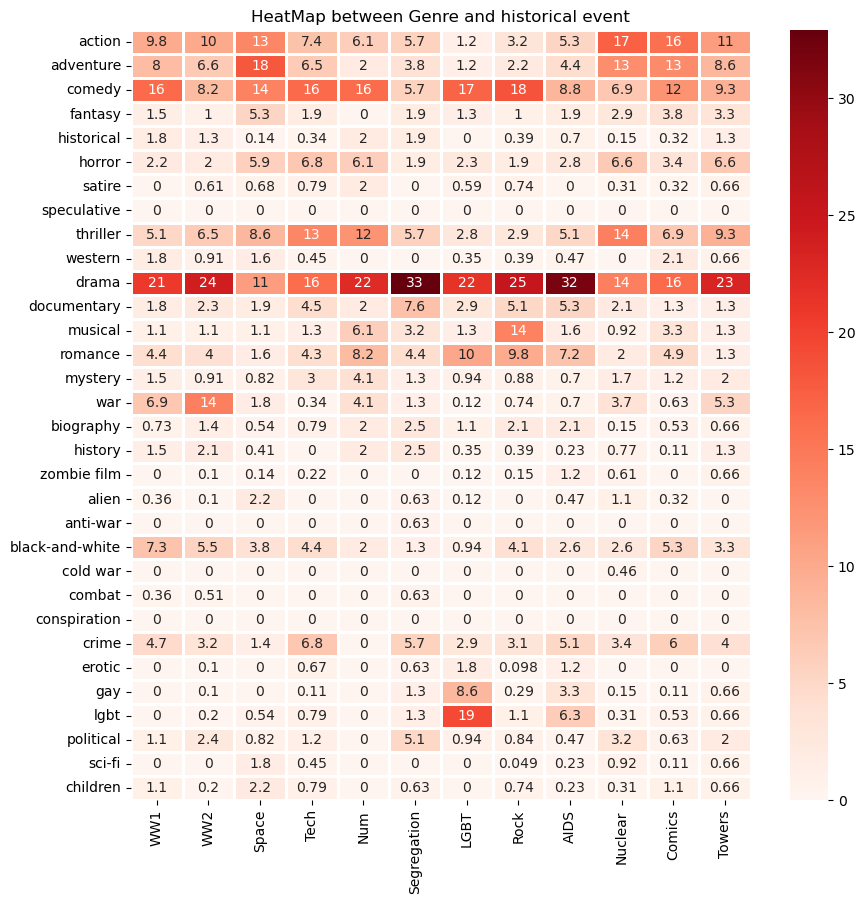

In [110]:
plt.figure(figsize=(10,10))
heat_map = sns.heatmap( dictionnary_genres, linewidth = 1 , annot = True, cmap='Reds')
plt.title( "HeatMap between Genre and historical event" )
plt.show()

As we can see from this heatmap, the genre **Drama** is the most present in our dataset which is relevant as it englobes imporant movie sub-categories. However, if we look at particularites, we can see relevent informations. Indeed, `WW1`and `WW2`are both classified as **Black-and-white**, **Thriller** and **horror** movies. In contrast, `Nuclear`and `Towers` are more set to **political** movies. Even there are some connections between `WW1`, `WW2`, `Nuclear`, and `Towers` movies as they both contain combat, murder and opposition themes, we can observe that their classification are different. So, specific dictionnaries are not equally classified. 

In constrast, `Tech`and `Num` are more general and don't show any genre specificity. Technologies in all forms are often used is various movie genres, which explains why. 

Both `Segregation`, `LGBT`, and `AIDS` are set to **documentary** as they generally want to represent past conditions. However, they can be distinguished by sub-genres, respectively **political**, **gay** and **romance**. 

Lastly, `Space` movies are classified into **fantasy** and **alien** categories being more related to exploration and innovation.

**From this heatmap we can see that the genres action and adventure are often associated to `SpaceRace` and `LGBT`, and drama movies often portray `WWII`, which is not surprising given the tragic events that occured during the period. Overall, there is no concrete conclusion to take from this plot, maybe because the genre names are too general to specifically target different historical events.** ***Est-ce u'on garde ?***

### Color code per historical event for plots:

One specific colour is assigned to a historical period to make it easier to compare each period's plots.

In [111]:
color_map = dict([
    ('WW1',['r']),
    ('WW2',['g']),
    ('Space',['b']),
    ('Tech',['k']),
    ('Segregation',['darkorchid']),
    ('LGBT',['pink']),
    ('AIDS',['cyan']),
    ('Rock',['y']),
    ('Num',['dodgerblue']),
    ('Nuclear',['orange']),
    ('Comics',['chocolate']),
    ('Towers',['grey'])
    
])

### Evolution of the number of movies representing a historical period with time 

In [112]:
analysis = {}
maximums = {}
for event in dictionnaries.index:
    analysis.update({event : time_analysis(event,thr=dictionnaries.loc[event].threshold, freq='2y')})
    maximums.update({event : max(analysis[event].number)}) #used to attribute y axis

The threshold used to identify the movies portraying each historical event was divided by 2 for these plots, allowing us to consider more movies. This allocates less specifically a movie to a given historical event but shows a more continuous evolution of the frequency of movies per year. The precision of the threshold is not as important in this exploratory phase, but we will need to refine it for later analysis in the project milestone 3.

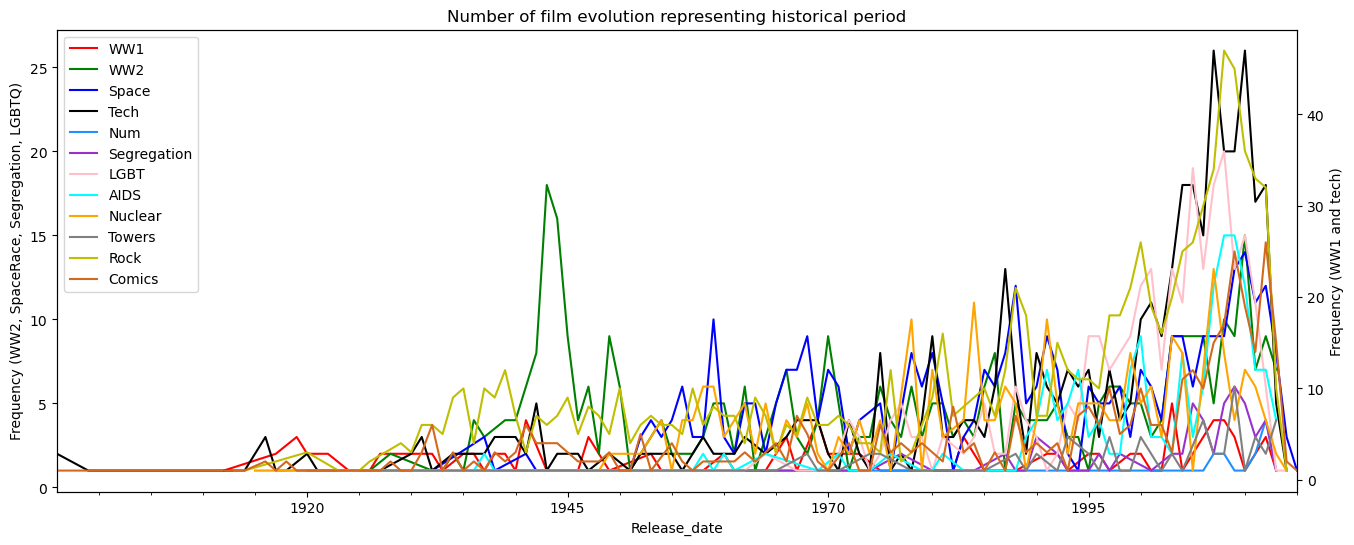

In [113]:
fig, ax1 = plt.subplots(figsize = (16,6))
ax2 = ax1.twinx()
for event in dictionnaries.index:
    ax = ax1
    #get the two events having biggest frequency to be plotted on a second y axis
    if event in [k for k,v in sorted(maximums.items(), key=lambda item: item[1])[-2:]] : ax = ax2
    analysis[event].number.plot(ax=ax, label=event, legend=True,color = color_map[event])

#manage legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.get_legend().remove()
ax2.get_legend().remove()
ax.legend(lines + lines2, labels + labels2)
    
ax1.set_ylabel('Frequency (WW2, SpaceRace, Segregation, LGBTQ)')
ax2.set_ylabel('Frequency (WW1 and tech)')

plt.title('Number of film evolution representing historical period')
plt.show()

A first observation stands out from this plot, there is an overall increase of the frequency of each historical movie over the years, which could be explained by the exponentially growing film industry. Then, the growing trends are punctated by peaks of frequency at specific time periods. Let us zoom in and analyze these curves individually to better capture the frequency fluctuations for each.

Text(0.02, 0.5, 'Number of movies')

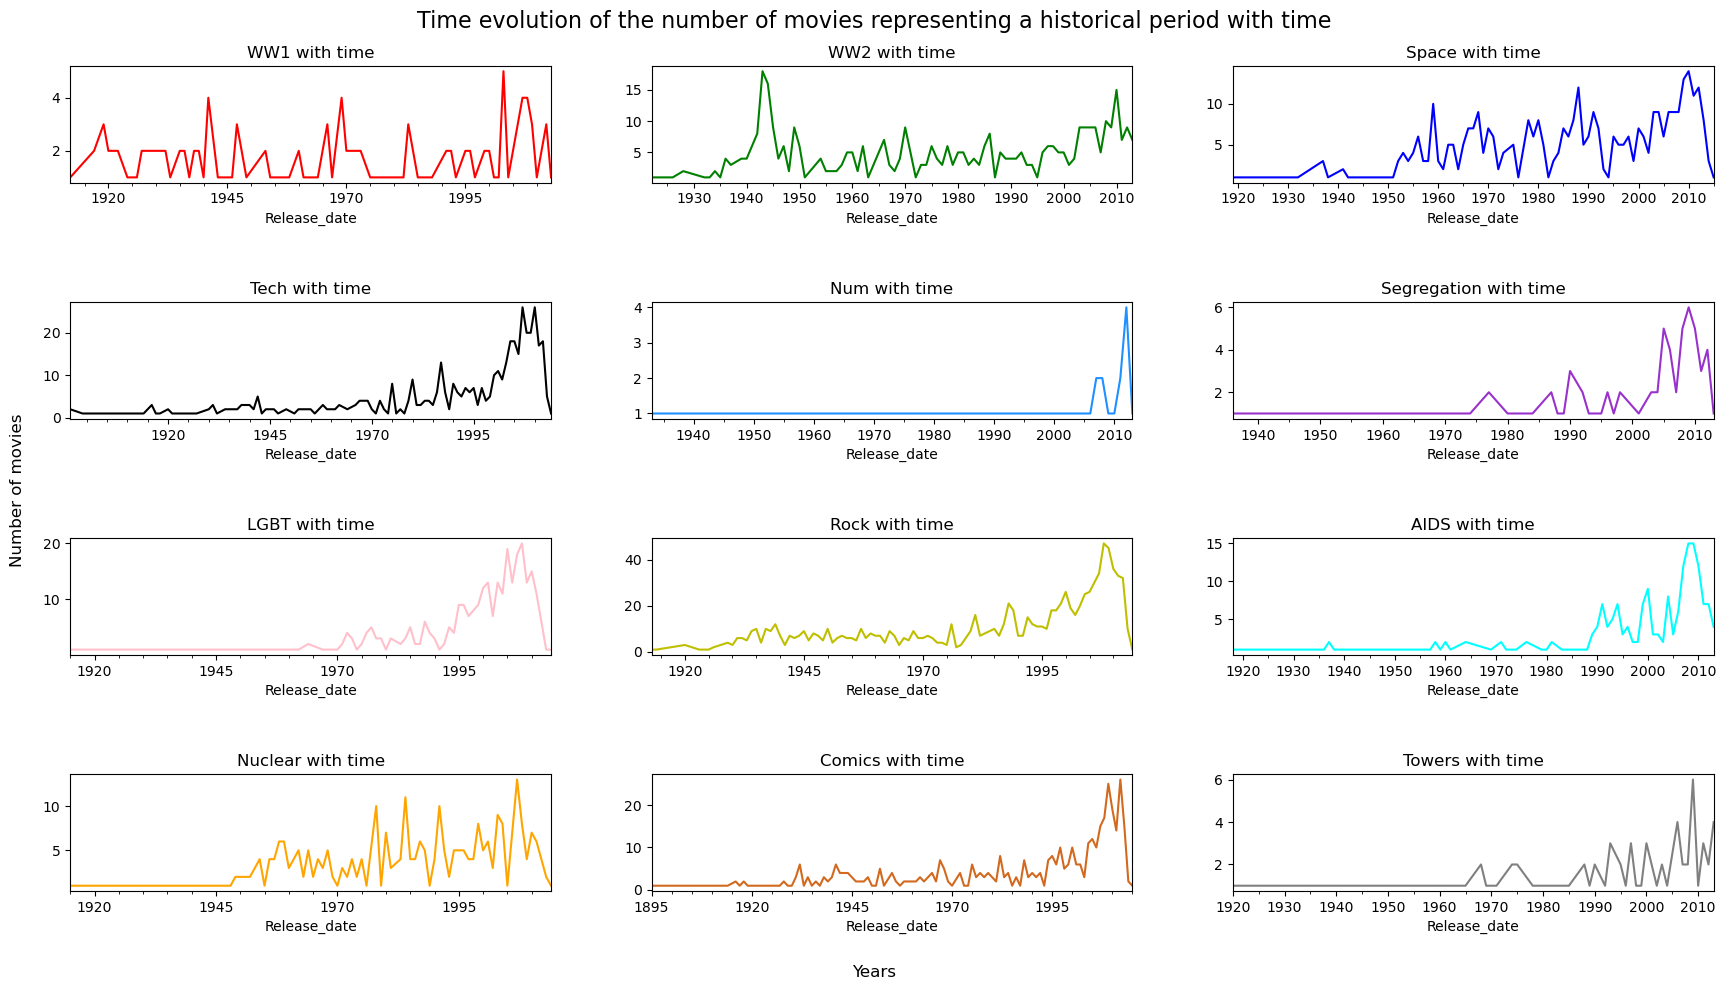

In [114]:
fig, axs = plt.subplots(4, 3, figsize=(18,10))
ax = axs.ravel()

for i,event in enumerate(dictionnaries.index):
    analysis[event].number.plot(ax=ax[i],label=event,title=f'{event} with time',color = color_map[event])
    
plt.tight_layout(pad=4)
fig.suptitle('Time evolution of the number of movies representing a historical period with time', fontsize=16)
fig.supxlabel('Years')
fig.supylabel('Number of movies')


For the historical films narrating `WWII`, an important peak in frequency appears from 1940 to 1950, during the last few years of the war itself and the years following it. These probably are propaganda movies which were widely shown to the public during the war; the Nazis were known to use films to create an image of the “national community”, whereas the allied countries portrayed them as cruel ennemies in their movies. Movies about the `technological and numerical revolution` significantly increased from the 1990s onwards, which were the years that marked the beginning of a [sequence of technological revolutions](https://www.zdnet.com/article/technology-that-changed-us-the-1990s/) such as the creation of the first web brouser World Wide Web, the first SMS text message, the foundation of Amazon followed by Google. The number of movies telling the story of `LGBTQ+ emancipation` tripled from 1995 to 2000 and then doubled again for the following years. This coincides with the beginning of the annual observance of LGBT History Month in the United States which was in 1994 and has since been picked up in other countries. For `space race` movies, a first smaller and long peak appears between 1950 and the end of 1970s, which could be due to the first satellites sent into orbit (1957), the first pilot-controlled space flight (1961) and the Apollo 11's successful mission in 1969. The frequency of these movies then increases from the 1980s onwards and a more important peak appears between 2005 and 2010, which were the periods where habitable exoplanets were discovered. 
`Rock` movies occurence start around 192 which corresponds to the early orign of the rock and roll music. The second "peak" between 1940-1950 correspond to the emergence the rock and roll as a define music. Then, we can see that there is an increases wich could correspond to the music evolution. 
The number of movies corresponding to the `Nuclear` historical period oscillate during time. Indeed, the first occurence of the uclear power in movies was in 1950 which correlates with the first atomic bomb of [Hiroshima and Nagasaki](https://en.wikipedia.org/wiki/Atomic_bombings_of_Hiroshima_and_Nagasaki). Then, this "new weapons" evolved with time until 1986 where there is a second peak which coincides in time with [Chernobyl](https://en.wikipedia.org/wiki/Chernobyl_disaster) event. 
Lastly, film about Twins Towers have the main occurence after 2005 which are years following the event, during which the world was still recovering from the traumatic event, governments installed anti-terrorist policies and most importantly the years during which the US was actively combatting Talibans in Afghanisan. However, we can observe some occurences before 2001 which can be associate with other terrorist movies.


These are examples of how historical events could influence the theme of movies released and the interests of our societies. 

### Evolution of the ratio of movies representing a historical period with time 

We then look at the ratio of each dictionnaries by 2 years to have an idea of the proportion of each dictionnary by time. 

In [115]:
def ratio_analysis(name,thr,freq = '5y'):
    """
    Parameters
    ----------
    name : the name of the dictrionnary
    Thr : Threshold of the corresponding dictrionnary
    freq : interval year for the groupby
        
    Returns
    -------
    ratio of number of movie per frequence
    """
    
    data = movies_plot.groupby(pd.to_datetime(movies_plot['Release_date']).dt.to_period(freq = freq)).apply(lambda x:
    #All kind of analysis:
        pd.Series({
            'ratio': len(x[x[name] > thr])/len(x) *100, #ratio for the dictrionnary
        })
    )
    return data

In [116]:
analysis = {}
maximums = {}
for event in dictionnaries.index:
    analysis.update({event : ratio_analysis(event,thr=dictionnaries.loc[event].threshold, freq='2y')})
    maximums.update({event : max(analysis[event].ratio)}) #used to attribute y axis

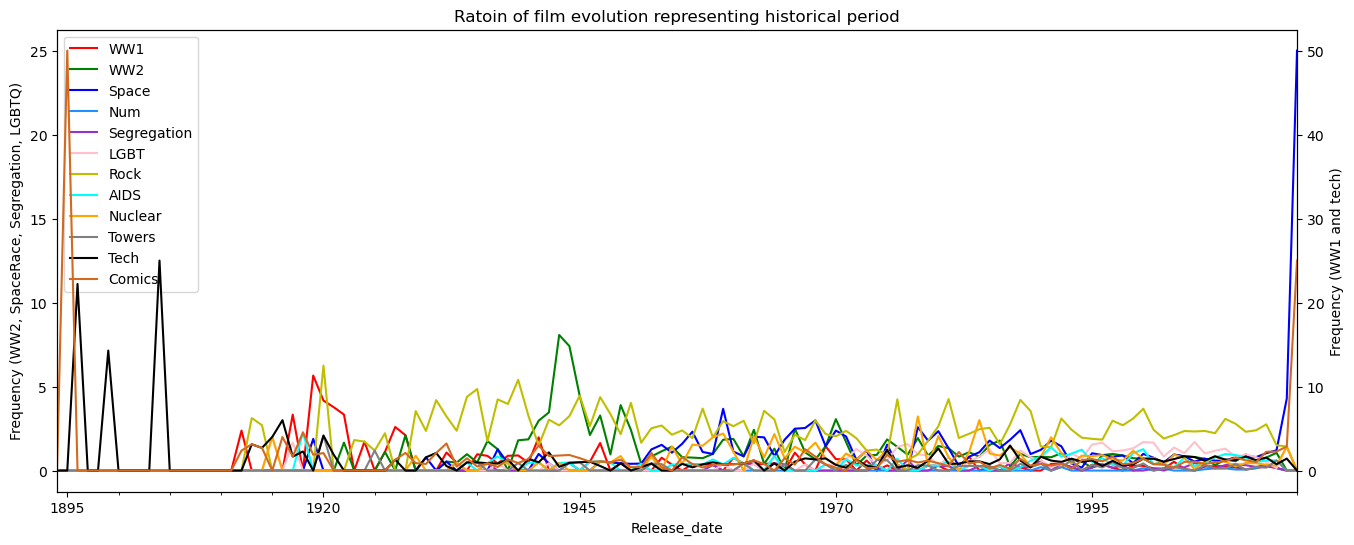

In [117]:
fig, ax1 = plt.subplots(figsize = (16,6))
ax2 = ax1.twinx()
for event in dictionnaries.index:
    ax = ax1
    #get the two events having biggest frequency to be plotted on a second y axis
    if event in [k for k,v in sorted(maximums.items(), key=lambda item: item[1])[-2:]] : ax = ax2
    analysis[event].ratio.plot(ax=ax, label=event, legend=True,color = color_map[event])

#manage legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.get_legend().remove()
ax2.get_legend().remove()
ax.legend(lines + lines2, labels + labels2)
    
ax1.set_ylabel('Frequency (WW2, SpaceRace, Segregation, LGBTQ)')
ax2.set_ylabel('Frequency (WW1 and tech)')


plt.title('Ratoin of film evolution representing historical period')
plt.show()

We saw previously that the number of movies realeased per year increased with time. With the ratio of each dictionnary, we can see that they all increase equally during time. Indeed, they are more or less constant with time. We can observe that `Rock` movies have a bigger ratio than the others during time periode. As mentionned before, it could be due to our unprecise dictionnary. 

At the begining of the cinema, only few movies were available and this was a new technology explaining the high ratio of `Tech`. 

We can see two peaks comparing to the basaline for the `WW1` between 1015 and 1920 and for the `WW2`between 1939 and 1946. So we will zoom in each individual plot. 

Text(0.02, 0.5, 'ratio')

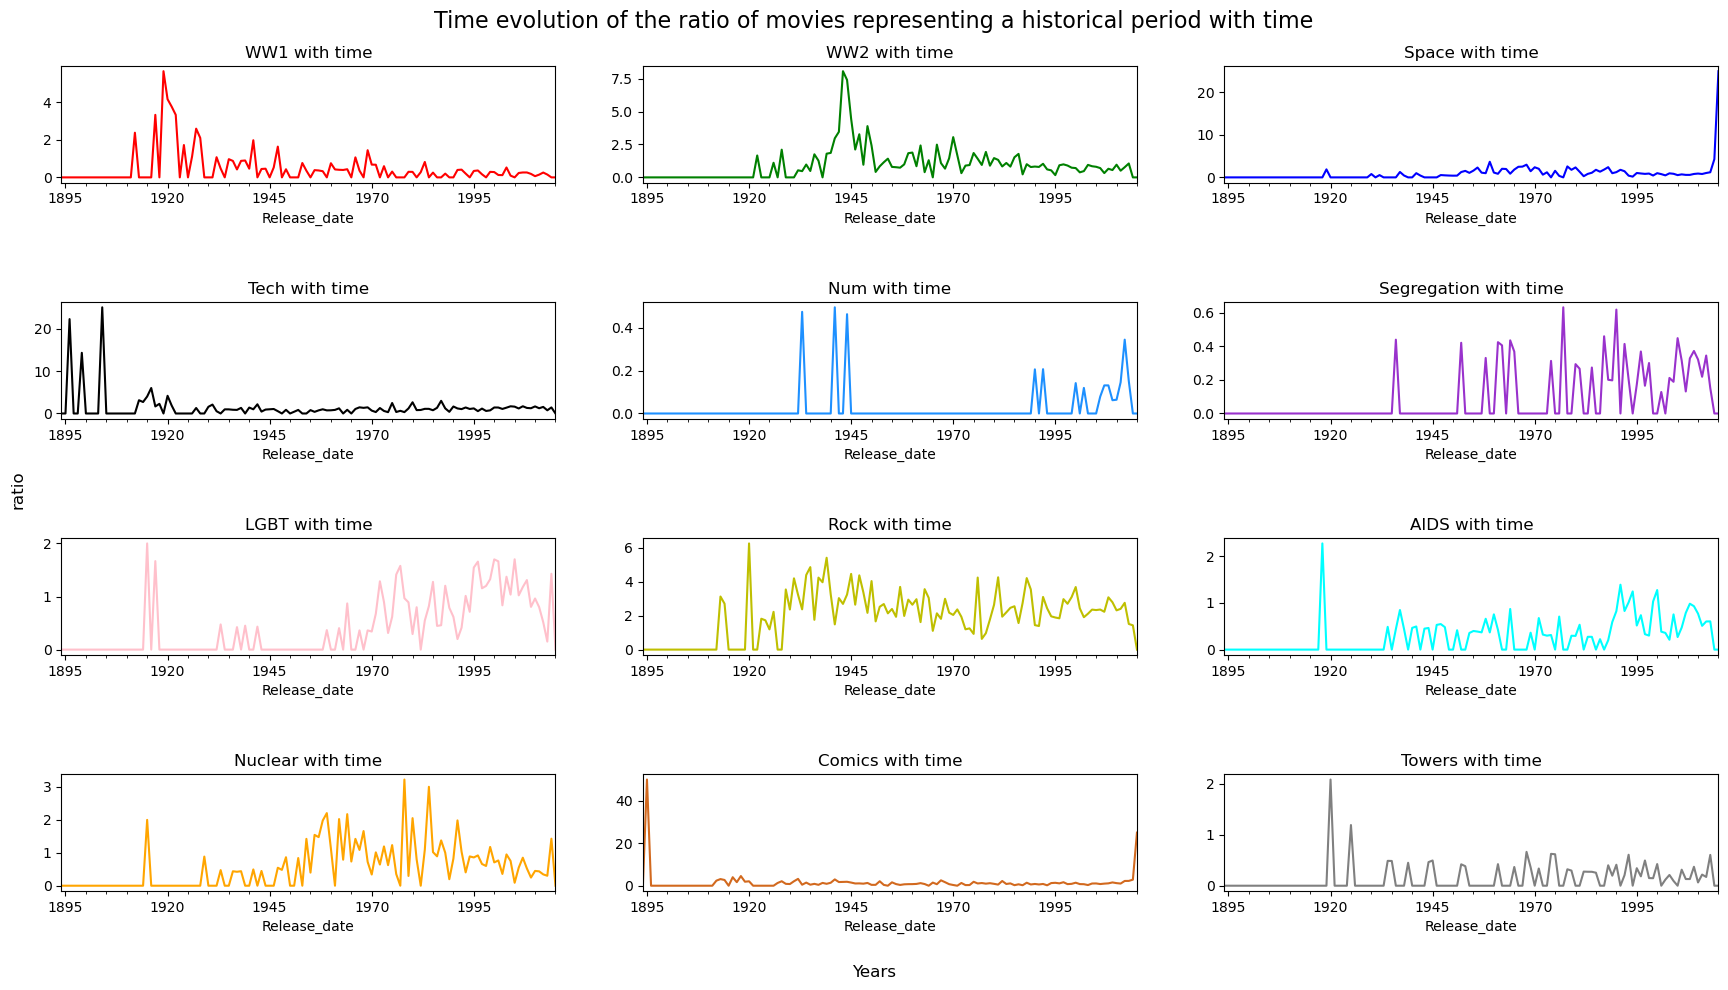

In [118]:
fig, axs = plt.subplots(4, 3, figsize=(18,10))
ax = axs.ravel()

for i,event in enumerate(dictionnaries.index):
    analysis[event].ratio.plot(ax=ax[i],label=event,title=f'{event} with time',color = color_map[event])
    
plt.tight_layout(pad=4)
fig.suptitle('Time evolution of the ratio of movies representing a historical period with time', fontsize=16)
fig.supxlabel('Years')
fig.supylabel('ratio')

We can see that most of the movie ratios tend to be linear during time. It is the case for `Space`, `Tech`, `Num`, `AIDS`and `Comics` where the ratiso are constant with time. However, each have a different baselines. 

However, some of the dictionnary show peaks. 
First, we can see that in the beginning of cinematographic era, peaks appear for `WW1`, `Tech`, and `Num` movies. As said before, it could be due to the fact that movie genres were not well defined and only few movies were created. 
As remarked before, there is a second peak in `WW1` between 1915 and 1925 which corresponds to the first world war and probably propaganda movies. We can observe the same trend during the Second World War where the movie ratio triples. 
Conserning `Segregation` and `LGBT` movies, the ratios oscillate between 0 and 2% with time. These movies are therefore not the major in the cinematographic business. This might be because documentaries are not as popular as action movies. Moreover, we can see that for each dictionnary, the first occurence correponds to the history appaerance. 
`Towers` and `Nuclear` movies have peaks around 1920 at 2% which is before the real history event. It could indicate that a movie can be miss classified. However, the other movie occurence tend to be related to the history. 

To look at more in deep information for each dictrionnary we look at the `Box_office_revenue`, the ratio of Woman, the average `Actor age`, the most `Country` that diffuse movie and the main actor.
To look at the time evolution into dictrionnary, we compare information between the historical event and between 2000-2010. With this information, we can observe the evolution of the historical representation. 

In [119]:
def TimeComparaison(feature, thr, time1, time2):
    """
    Parameters
    ----------
    Feature : name of the dictionnary
    thr : threshold of the corresponding dictionnary
    time1 : array of [t1,t2] corresponding the the first interval of time
    time1 : array of [t1,t2] corresponding the the first interval of time
        
    Returns
    -------
    list with the information of each time interval [t1, t2], each time containing : 
    [mean Box_office_revenue, mean Actor age, ratio of woman, Famous actor, main country]
    """
    
    movies_feature = movies_plot[movies_plot[feature] > thr].copy()
    movies_feature['Release_date'] = movies_feature['Release_date'].dt.to_period('Y')
    
    movies_filter1 = movies_feature.loc[(movies_feature['Release_date'] >= time1[0]) & (movies_feature['Release_date'] < time1[1])].copy()
    movies_filter2 = movies_feature.loc[(movies_feature['Release_date'] >= time2[0]) & (movies_feature['Release_date'] < time2[1])].copy()
    
    movies_filter1 = movies_filter1.merge(characters, on="Wikipedia_movie_ID", suffixes=('', '_y'))
    movies_filter2 = movies_filter2.merge(characters, on="Wikipedia_movie_ID", suffixes=('', '_y')) 
    
    t1 = [[movies_filter1[movies_filter1.Box_office_revenue.notna()].copy().Box_office_revenue.mean(), movies_filter1[movies_filter1.Age_at_movie_release.notna()].copy().Age_at_movie_release.mean(),
          len(movies_filter1[movies_filter1.Actor_Gender == 'F'])/len(movies_filter1.Actor_Gender)*100, movies_filter1.Actor_Name.value_counts().to_frame().index[0],
         movies_filter1.Countries.value_counts().to_frame().index[0]]]
    
    t2 = [[movies_filter2[movies_filter2.Box_office_revenue.notna()].copy().Box_office_revenue.mean(), movies_filter2[movies_filter2.Age_at_movie_release.notna()].copy().Age_at_movie_release.mean(),
          len(movies_filter2[movies_filter2.Actor_Gender == 'F'])/len(movies_filter2.Actor_Gender)*100, movies_filter2.Actor_Name.value_counts().to_frame().index[0],
         movies_filter2.Countries.value_counts().to_frame().index[0]]]
    
    return [t1,t2]
   

To analyse parameters during time, we first chose the two interval of time for each dictrionnary.

In [120]:
time_interval = {'WW1':['1913', '1919', '2000', '2010'], 
        'WW2':['1938', '1946', '2000', '2010'],
        'Space':['1957', '1975', '2000', '2010'],
        'Tech':['1900', '1921', '2000', '2010'],
        'Num':['1930', '1946', '2000', '2010'],
        'Segregation':['1955', '1961', '2000', '2010'],
        'LGBT':['1959', '1971', '2000', '2010'],
        'Rock':['1950', '1965', '2000', '2010'],
        'AIDS':['1970', '1980', '2000', '2010'],
        'Nuclear':['1945', '1960', '2000', '2010'],
        'Comics':['1920', '1930', '2000', '2010'],
        'Towers':['1970', '1980', '2000', '2010']
       }
time_interval = pd.DataFrame(time_interval, index=['time1_1', 'time1_2', 'time2_1', 'time2_2'])


event_time = pd.DataFrame(columns=['Box_office_revenue', 'Average_actor_age', 'Woman_ratio', 'Popular_Actor', 'Main_country'] )



In [121]:
for event in dictionnaries.index:
    tmps = TimeComparaison(event, thr=dictionnaries.loc[event].threshold, time1=[time_interval[event].time1_1, time_interval[event].time1_2], time2=[time_interval[event].time2_1, time_interval[event].time2_2])
    df0=pd.DataFrame(tmps[0],columns=[ 'Box_office_revenue', 'Average_actor_age', 'Woman_ratio', 'Popular_Actor', 'Main_country'], index=[event + ' ' + time_interval[event].time1_1 +'-'+ time_interval[event].time1_2])
    df1=pd.DataFrame(tmps[1],columns=[ 'Box_office_revenue', 'Average_actor_age', 'Woman_ratio', 'Popular_Actor', 'Main_country'], index=[event + ' ' + time_interval[event].time2_1 +'-'+ time_interval[event].time2_2])
    event_time = pd.concat([event_time, df0, df1], axis=0)

In [122]:
event_time

,Box_office_revenue,Average_actor_age,Woman_ratio,Popular_Actor,Main_country
WW1 1913-1919,NaN,NaN,20.000000,Fred Niblo,united states of america
WW1 2000-2010,4.934679e+07,38.147436,22.685185,Jacob Vargas,united states of america
WW2 1938-1946,3.700000e+06,29.739796,18.656716,Duncan Renaldo,united states of america
WW2 2000-2010,1.440902e+08,39.814745,24.830393,Christian Berkel,united states of america
Space 1957-1975,8.386802e+06,38.509434,22.831858,Moe Howard,united states of america
Space 2000-2010,8.212761e+07,39.455466,25.657895,Cem Yılmaz,united states of america
Tech 1900-1921,NaN,-4.750000,27.027027,Charlie Chaplin,united states of america
Tech 2000-2010,1.087284e+08,37.407268,30.870279,Conrad Vernon,united states of america
Num 1930-1946,NaN,15.000000,33.333333,Constance Cummings,united states of america
Num 2000-2010,9.124420e+05,33.263158,33.333333,Rachael Taylor,united states of america


## Movement of genres with time 

meme chose que les dico mais sur des principes plus large

### Romance

In [123]:
Romance = ['Mariage', 'love', 'passion', 'emotion', 'sentiment', 'union', 'relation', 'deep love', 'dating', 'temptations', 'infidelity',
           'love at first sight', 'finding the man', 'finding the woman', 'happy ending', 'girlfriend', 'boyfriend', 'engaging', 'true love',
           'romantic', 'wedding', 'proposal', 'kiss']
Romance = [x.lower() for x in Romance]

### War

In [124]:
War = ['war', 'weapons', 'army', 'terror', 'conquest', 'soldier', 'conflict', 'warship', 'battle', 'battlefield', 'fight', 'combat',
      'bloodshed', 'fighting', 'engagement', 'bombard', 'attack', 'go to war', 'kill', 'Navy']
War = [x.lower() for x in War]

### Comedy

In [125]:
Comedie = ['happy end', 'fraternity', 'college', 'party', 'family', 'ridiculous', 'impossible', 'funny', 'embarrassing', 'farce', 'sitcom',
          'humor', 'satire', 'camp']
Comedie = [x.lower() for x in Comedie]

### Drama

In [126]:
Drama = ['death', 'misery', 'toxic', 'tragic', 'tragical', 'carcrash']
Drama = [x.lower() for x in Drama]

### Western

In [127]:
Western = ['Cowboy', 'Country', 'rodeo', 'ranch', 'farwest', 'cow', 'saloon', 'colonial', 'gunslingers', 'revolvers ', 'frontier justice',
          'landscape', 'Valley', 'horseback', 'settlers', 'Apache ', 'Indian' ]
Western = [x.lower() for x in Western]

### Aventure

In [128]:
Adv = ['experience', 'trip', 'exploit', 'explore', 'pirate ', 'escape', 'discovers',  'operation', 'exploration', 'quest', 'mission',
      'adventure', 'mystery']
Adv = [x.lower() for x in Adv]

### Fantastique

In [129]:
Fantastic = ['Innovation', 'alien', 'implausible', 'imaginative', 'moon', 'spacecraft ', 'dragons', 'Martians', 'gost', 'extraterrestrial ', 
             'new technology ', 'chaos', 'power', 'wizardry', 'magical', 'invention', 'unicorn', 'sorcerer', 'mermaid', 'dreams', 'wolf', 'zombies', 'predator', 'immortal' ]
Fantastic = [x.lower() for x in Fantastic]

### Horror

In [130]:
Horror = ['fear', 'fright', 'awe', 'apprehension', 'dark', 'shadows', 'spirit', 'gost', 'voices', 'revenge ', 'traumatic', 'incident', 
         'experiencing', 'vengeful', 'stranger', 'serial killer', 'mysterious', 'demons', 'disappear', 'noises', 'nightmares', ]
Horror = [x.lower() for x in Horror]

### Comics

In [131]:
Comics = ['cartoons', 'funny', 'power', 'fight evil', 'peace', 'justice', 'supernatural',  'invincible', 'Batman', 'Gotham', 'superheroe',
          'the shadow', 'criminal','heroe', 'evil', 'iron man', 'corruption', 'the avengers', 'loki', 'protector', 'masked', 'enemy', 'superman',
          'magical powers', 'X-men', 'mutants']
Comics = [x.lower() for x in Comics]

In [132]:
genders = {'words_list': [Romance,War,Comedie,Drama,Western,Adv,Fantastic,Horror,Comics]}
dictionnarie = pd.DataFrame(data=genders, index=['Romance', 'War', 'Comedie', 'Drama', 'Western', 'Adv', 'Fantastic', 'Horror', 'Comics'])

In [133]:
dictionnarie = pd.concat([dictionnarie,pd.DataFrame(data=get_thresholds(dictionnarie),index=dictionnarie.index)], axis=1)
dictionnarie

,words_list,threshold
Romance,"[mariage, love, passion, emotion, sentiment, u...",0.00925
War,"[war, weapons, army, terror, conquest, soldier...",0.00850
Comedie,"[happy end, fraternity, college, party, family...",0.00700
Drama,"[death, misery, toxic, tragic, tragical, carcr...",0.00500
Western,"[cowboy, country, rodeo, ranch, farwest, cow, ...",0.00775
Adv,"[experience, trip, exploit, explore, pirate , ...",0.00675
Fantastic,"[innovation, alien, implausible, imaginative, ...",0.00950
Horror,"[fear, fright, awe, apprehension, dark, shadow...",0.00875
Comics,"[cartoons, funny, power, fight evil, peace, ju...",0.01000


In [134]:
dictionnarie.index.to_series().apply(lambda i : count_dict(i,dictionnarie.loc[i].words_list));

In [135]:
def get_genre_features(genre,features):
    """
    Parameters
    ----------
    event : column name of a historical event
    features : list of features to return
        
    Returns
    -------
    Return features of movies that are associated to a particular event.
    """
    return movies_plot[movies_plot[genre] > dictionnarie.loc[genre].threshold][features]

In [136]:
def genre_word_clouds(genre):
    """
    Parameters
    ----------
    event : column name of a historical event
        
    Returns
    -------
    Return a WorldCloud object computed on all summaries classified a part of event.
    """
    # get the summaries classified in event and join them because WordCloud only accepts strings
    v = " ".join(text for text in get_genre_features(genre,['Summary']).Summary) 
    return WordCloud(collocations = False, background_color = 'white', stopwords=stop_words).generate(v)

In [ ]:
# Plot word clouds
fig, axs = plt.subplots(3, 3, figsize=(15,5))
axravel = axs.ravel()
for i,genre in enumerate(dictionnarie.index):
    axravel[i].imshow(genre_word_clouds(genre), interpolation="bilinear")
    axravel[i].set_title(f"{genre} vocabulary")
    axravel[i].axis('off')

In [138]:
color_genre = dict([
    ('Romance',['pink']),
    ('War',['k']),
    ('Comedie',['b']),
    ('Drama',['orange']),
    ('Western',['darkorchid']),
    ('Adv',['g']),
    ('Fantastic',['cyan']),
    ('Horror',['y']),
    ('Num',['dodgerblue']),
    ('Comics',['chocolate'])
    
])

In [139]:
analysis = {}
maximums = {}
for genre in dictionnarie.index:
    analysis.update({genre : ratio_analysis(genre,thr=dictionnarie.loc[genre].threshold, freq='2y')})
    maximums.update({genre : max(analysis[genre].ratio)}) #used to attribute y axis

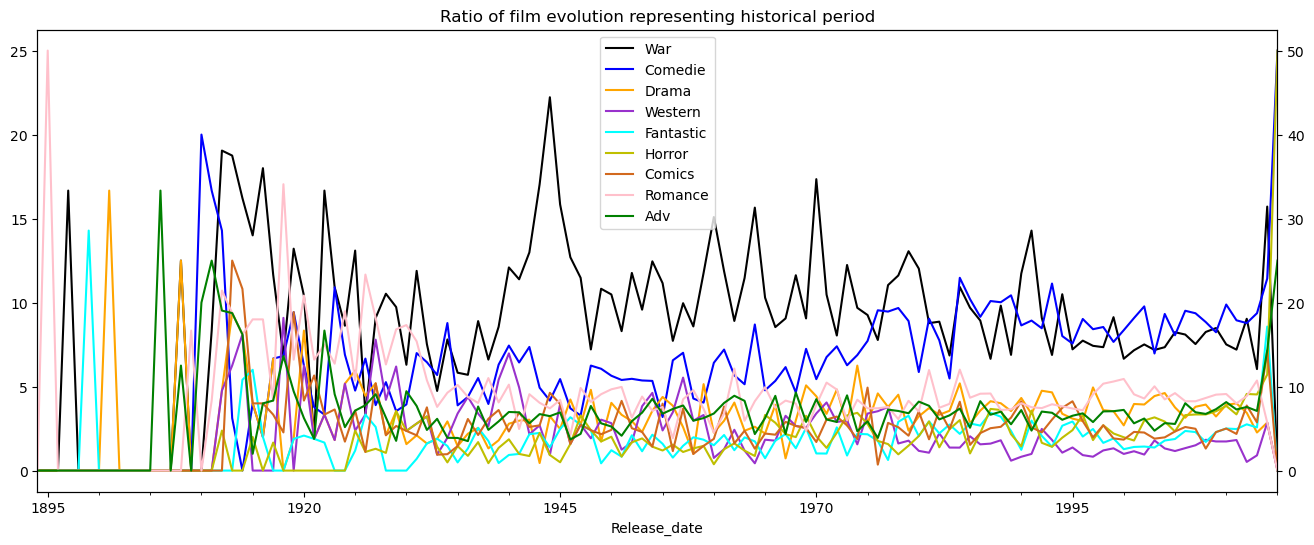

In [140]:
fig, ax1 = plt.subplots(figsize = (16,6))
ax2 = ax1.twinx()
for genre in dictionnarie.index:
    ax = ax1
    #get the two events having biggest frequency to be plotted on a second y axis
    if genre in [k for k,v in sorted(maximums.items(), key=lambda item: item[1])[-2:]] : ax = ax2
    analysis[genre].ratio.plot(ax=ax, label=genre, legend=True,color = color_genre[genre])

#manage legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.get_legend().remove()
ax2.get_legend().remove()
ax.legend(lines + lines2, labels + labels2)
    
#ax1.set_ylabel('Frequency (WW2, SpaceRace, Segregation, LGBTQ)')
#ax2.set_ylabel('Frequency (WW1 and tech)')


plt.title('Ratio of film evolution representing historical period')
plt.show()

Text(0.02, 0.5, 'ratio')

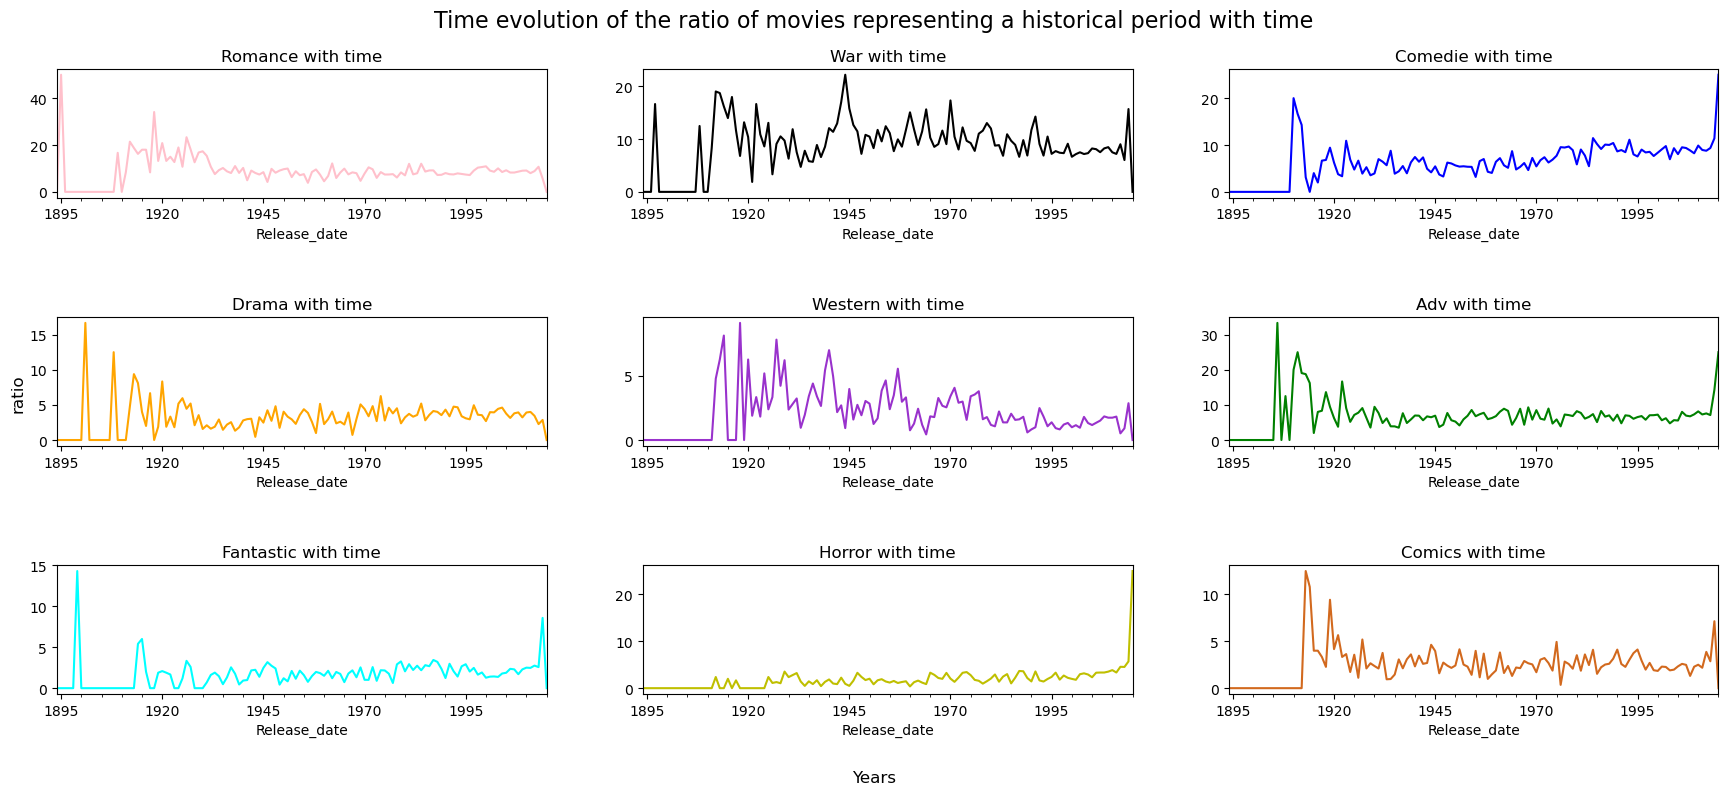

In [141]:
fig, axs = plt.subplots(3, 3, figsize=(18,8))
ax = axs.ravel()

for i,genre in enumerate(dictionnarie.index):
    analysis[genre].ratio.plot(ax=ax[i],label=genre,title=f'{genre} with time',color = color_genre[genre])
    
plt.tight_layout(pad=4)
fig.suptitle('Time evolution of the ratio of movies representing a historical period with time', fontsize=16)
fig.supxlabel('Years')
fig.supylabel('ratio')

### Evolution of the box office revenue of movies representing a historical period with time 

In [142]:
def plot_distr(name,thr,xname,yname,glm=LinearRegression(),logy=False,axis=plt,color = 'r'):
    """        
    Parameters
    ----------
    name : name of the historical event
    thr : threshold for accepting the movie as portraying the event
    xname : name of the column we want on x axis
    yname : name of the column we want on y axis
    glm : glm method to use (https://scikit-learn.org/0.15/modules/linear_model.html)
    logy : True if we want the y axis in log scale
    axis : axis to plot on, default : plt for single figure
        
    Returns
    -------
    Plots the two features selected relative to each other and their linear regression.
    """
    
    #get movies classified as specific historical event (here called 'name') 
    time_dist = movies_plot[movies_plot[name] > thr].copy()
    
    #special processing if dealing with 'Release_date' feature
    if xname=='Release_date' or yname=='Release_date' :
        pd.options.mode.chained_assignment = None  # default='warn' # get rid of warnings
        time_dist['Release_date'] = pd.to_datetime(time_dist['Release_date']).dt.year
        pd.options.mode.chained_assignment = 'warn'  # default='warn' # put warnings back
    
    time_dist = time_dist.dropna()
    
    #define Y and X
    Y = time_dist[yname]
    if logy : 
        Y = Y.apply(lambda x : np.log(x))
        yname = 'Log '+ yname
    
    X = np.array(time_dist[xname]).reshape(-1, 1)
    
    #scatter plot
    axis.scatter(time_dist[xname],Y,c=color,label = f'{name} movie', s=1.5)
    
    #regression fit and plot
    reg = glm.fit(X,Y)
    t = np.array(np.linspace(time_dist[xname].min(),time_dist[xname].max(),1000)).reshape(-1,1)
    axis.plot(t,reg.predict(t),'-',label = str(glm))
    
    #manage axis
    if axis == plt : #use Axes syntax
        axis.legend()
        axis.xlabel(xname)
        axis.ylabel(yname)
        axis.title(f'{yname} distribution for {name} event')
    else : #use Axes.subplots syntax
        axis.legend()
        axis.set_xlabel(xname)
        axis.set_ylabel(yname)
        axis.set_title(f'{yname} distribution for {name} event')

    return 

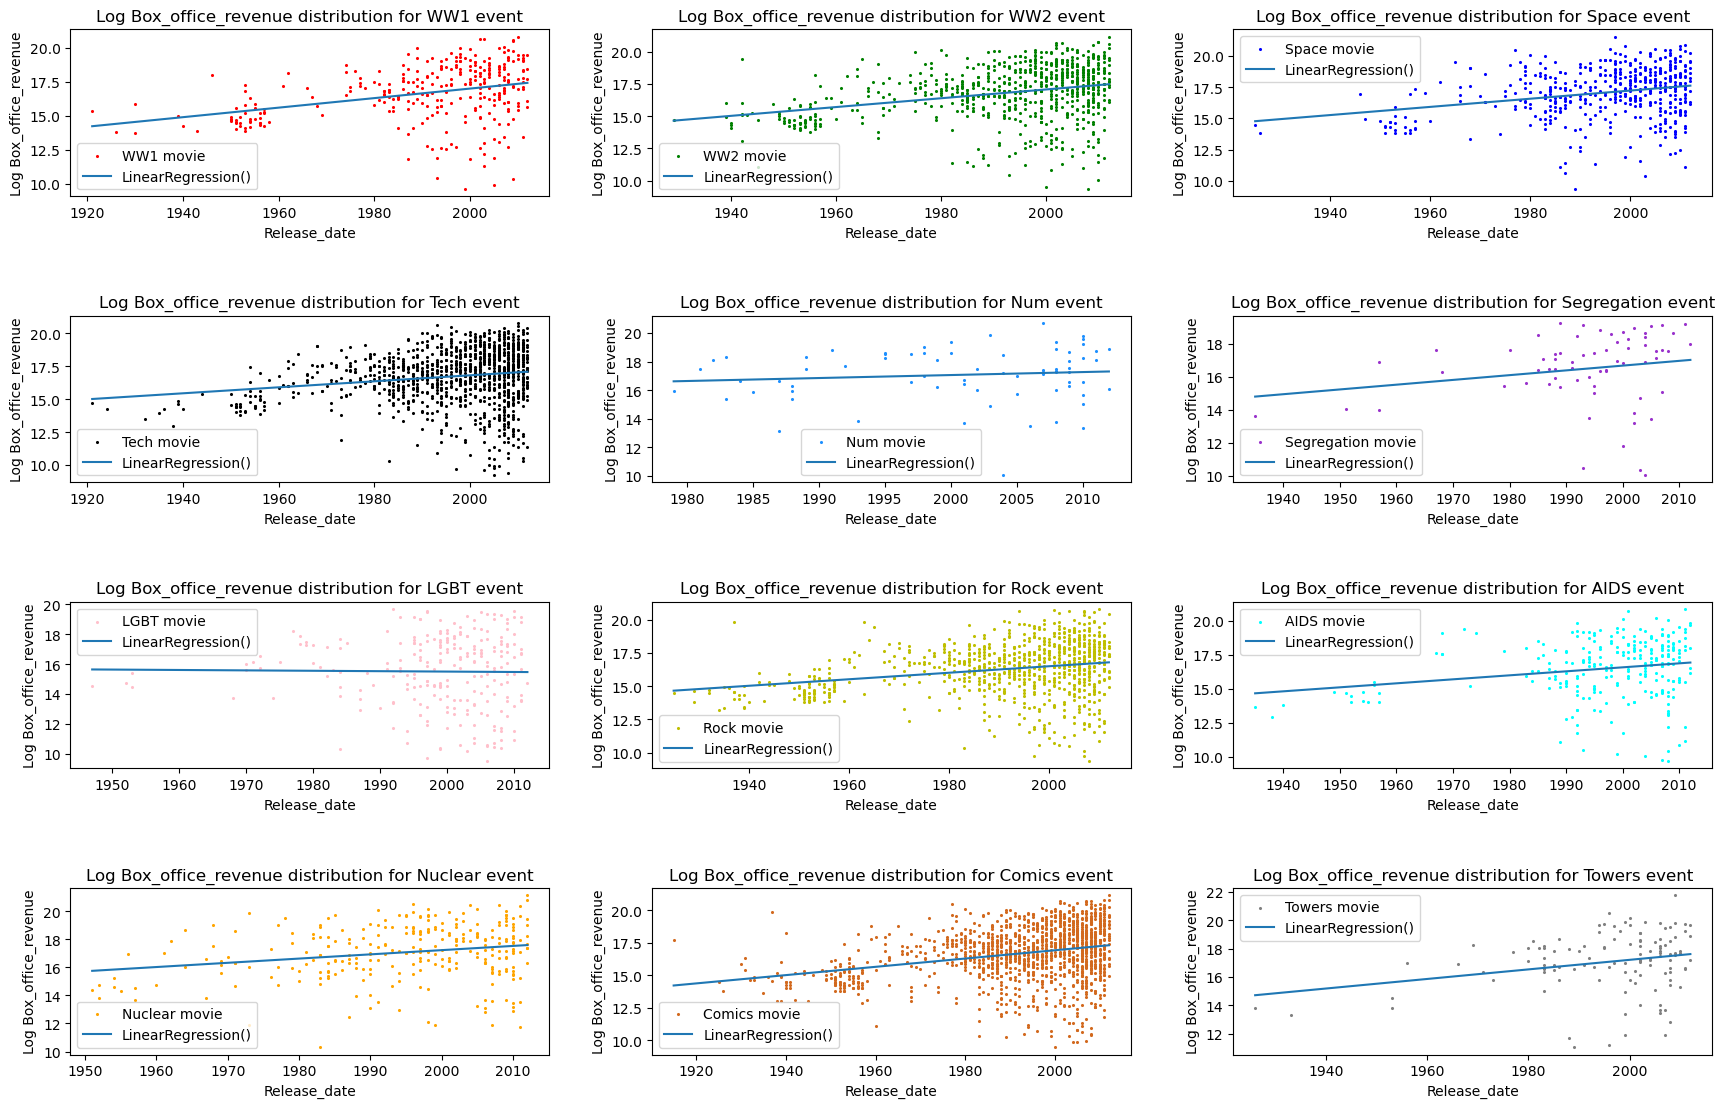

In [143]:
fig, axs = plt.subplots(4, 3, figsize=(18,12))
ax = axs.ravel()

for i,event in enumerate(dictionnaries.index):
    #threshold = dictionnaries.loc[event].threshold
    plot_distr(event,0,'Release_date','Box_office_revenue',logy=True,axis=ax[i],color = color_map[event][0])

plt.tight_layout(pad=4)

These plots display the distributions per year of the box office revenues of the movies linked to the historical period we defined earlier. A linear regression is added to each plot to capture the mean tendancy of the distributions. We see that all our features, except for the LGBT movies, the box office revenue has a tendancy to grow on average. It follows the same trend as seen at the beginning of the notebook with the mean box office revenue per year increasing. On the other hand, LGBT movies seems to be quite stable (the linear regression is almost flat). However, we can see that most of the movies have been released in recent years, thus limiting the linear regression slope. 

Further analysis could be conducted with linear regression (for milestone 3): several additionnal statistics could bring us information on the spread of the data points or the confidence on our regression parameters (R squared, p-values or residuals for example). Multiple feature linear regression could also be used later on to relate fetaures between them.

## PCA 

Let us define the features we will use in the PCA and that we will normalize. We could define more features by introducing character information (i.e. gender ratio, age, height etc..), all that is needed is the computation and fusion of dataframes. However, to start we will stick to more simple features and study the space we created thanks to our historical period features.

In [144]:
features = ['Box_office_revenue','WW1','WW2','Space','Tech','LGBT','Segregation', 'Rock', 'AIDS', 'Nuclear', 'Comics', 'Towers']
PCAfeature = movies_plot[features].dropna()
PCAfeature= preprocessing.StandardScaler().fit(PCAfeature).transform(PCAfeature) #standardize
print(np.mean(PCAfeature,axis = 0),np.std(PCAfeature,axis = 0))

color_map = dict([
     ('WW1',['r']),
    ('WW2',['g']),
    ('Space',['b']),
    ('Tech',['k']),
    ('Segregation',['darkorchid']),
    ('LGBT',['pink']),
    ('AIDS',['cyan']),
    ('Rock',['y']),
    ('Num',['dodgerblue']),
    ('Nuclear',['orange']),
    ('Comics',['chocolate']),
    ('Towers',['grey']),
    ('Box_office_revenue',['c'])
])

[ 2.66910083e-17 -1.35796358e-17  3.74610642e-18 -1.05359243e-17
 -3.74610642e-18  2.43496917e-17  9.36526606e-18 -4.77628569e-17
 -3.37149578e-17  6.55568624e-18  3.51197477e-17  1.87305321e-18] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Proportion of variance explained (%): PC1 0.10984030743289212, PC2 0.10394628257697353


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


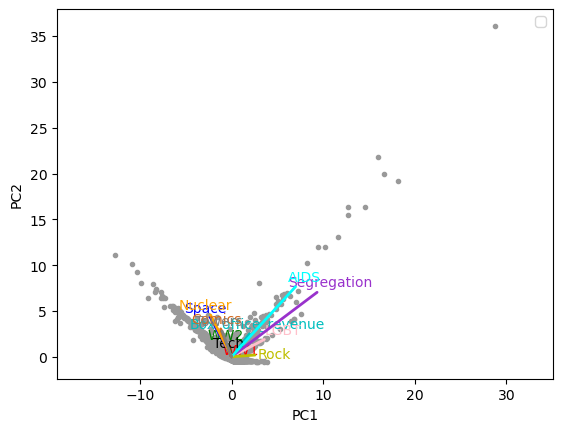

Mean along PC1 and PC2:  1.8730532114408863e-18 1.873053211440886e-17


In [148]:
pca = PCA(2)  
projected = pca.fit_transform(PCAfeature)
print(f'Proportion of variance explained (%): PC1 {pca.explained_variance_ratio_[0]}, PC2 {pca.explained_variance_ratio_[1]}')
#print(pca.components_)
ax = plt.gca()

for i,f in enumerate(features):
    c = color_map[f][0]
    ax.annotate(f,[0,0],15*(pca.components_[:,i]),arrowprops= dict(arrowstyle='-',linewidth=2,shrinkA=0,shrinkB=0, color = c),color= c)
    #print(np.linalg.norm(10*pca.components_[:,i]/np.linalg.norm(pca.components_[:,i])))
plt.plot(projected[:, 0], projected[:, 1],'.',color = '0.6')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.legend()
plt.show()
print('Mean along PC1 and PC2: ',np.mean(projected[:, 0]), np.mean(projected[:, 1]))

This plot shows all the movies, represented by the features mentionned above, projected onto the two first principal components. The features axis are also projected onto this space and scaled up to be seen. 

We can first note that a lot of movies are contained near the origin. The datapoints have a preferenced direction of spread (extreme values are directed towards large PC axis value). Then, several features seem to point towards the PC1, illustrating the highest variance direction in the dataset. We can also assume that two features are correlated if their projected axis are close to eachother: the PC1 is a linear combination of several features pointing in the direction where the most spread is present. Following this reasoning, the `WW1` and `box office revenue` features are quite correlated. The `tech` and `space race` are also related to the PC1. 
The `LGBT`features is almost only projected onto the PC2, indicating the second direction of highest variance. It also shows that `LGBT` is not correlated to the PC1 and therefore not correlated to `WW1`, `box office revenue` etc... `Segregation` is also very close to the PC2. 

However, only 35 to 40% of variance is explained by the two first PCs, meaning that a lot of variance is still contained in other dimensions not visible here.

## LDA Topic Analysis of movies categorized into historical events

In [147]:
nlp = spacy.load('en_core_web_sm')

Before applying NLP models onto our movie lot summeries, it is important to preprocess the raw text to improve the model's performance. Stopword, punctutation, numbers and white space removal is applies as well as casefolding.

In [152]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def clean(text):
    
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text)
    
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text)  # do we want to keep numbers ?
    
    # remove whitespaces 
    text = ' '.join(text.split())
    
    # convert text to lowercase 
    text = text.lower() 
    
    # remove words that have less than 3 letters
    no_short_word = [w for w in text.split() if len(w) > 2]
    text = ' '.join(no_short_word)
    
    # remove stopwords
    no_stopword_text = [w for w in text.split() if not w in spacy_stopwords]
    text = ' '.join(no_stopword_text)
    
    return text

In [153]:
def df_event(event_name):
    """
    Parameters
    ----------
    event : column name of a historical event
    features : list of features to return
        
    Returns
    -------
    Return features of movies that are associated to a particular event.
    """
    dictionnaries.index.to_series().apply(lambda i : movies_event.update({i : get_event_features(i,['Summary'])}));
    df_event = movies_event[event_name]
    df_event['Hist_event'] = event_name
    
    return df_event

In [154]:
hist_events = []
for event in movies_event.keys():
    hist_events.append(df_event(event))

df_movie_events = pd.concat(hist_events).reset_index()
df_movie_events

,index,Summary,Hist_event
0,76,The film opens with a woman walking her dog do...,WW1
1,823,In August 1914 a consignment of Vickers machin...,WW1
2,921,"Morris ""Mud"" Himmel has a problem – his parent...",WW1
3,1025,"An adventuress, Cora Williams destroys the ha...",WW1
4,2269,Radio producer John Guedel is panicked and dum...,WW1
...,...,...,...
5102,39194,A government-controlled society. Former nude m...,Towers
5103,40650,The story takes place in 1903. During a train ...,Towers
5104,41280,"The film is set in modern Kuttanad, Kerala, an...",Towers
5105,41339,Police Constable Don Ross uncovers a group of...,Towers


In [157]:
df_movie_events['clean_plot'] = df_movie_events['Summary'].apply(lambda x: clean(x))
df_movie_events["tokenized"]=df_movie_events["clean_plot"].apply(lambda x: nltk.word_tokenize(x))

LDA is used to classify text in a document to a particular topic. It does so by building a topic per document model and words per topic model, modeled as Dirichlet distributions, which is where its name Latent Dirichlet Allocation comes from. 

The input of the LDA model takes the movie plot summaries in a tokenized form should be in the format of document-term matrix, this conversion is done below. Prior to topic modelling, the tokenized text needs to be converted to a bag of words, which can be interpreted as a dictionary where the key is the word and value is the number of times that word occurs in the entire plot summary. 

In [158]:
from gensim import corpora

dictionary = corpora.Dictionary(df_movie_events["tokenized"])
doc_term_matrix = [dictionary.doc2bow(rev) for rev in df_movie_events["tokenized"]]

In [159]:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=len(movies_event.keys()), random_state=100,
                chunksize=200, passes=100)

La cellule au dessus mets environs 11 mins à run

In [160]:
lda_model.print_topics()

[(0,
  '0.008*"power" + 0.007*"superman" + 0.006*"nuclear" + 0.006*"earth" + 0.006*"world" + 0.005*"batman" + 0.004*"planet" + 0.004*"destruction" + 0.004*"space" + 0.004*"new"'),
 (1,
  '0.008*"father" + 0.007*"finds" + 0.007*"police" + 0.006*"criminal" + 0.006*"man" + 0.006*"family" + 0.005*"home" + 0.005*"house" + 0.005*"love" + 0.005*"son"'),
 (2,
  '0.024*"com" + 0.018*"supernatural" + 0.017*"www" + 0.015*"http" + 0.014*"bond" + 0.013*"nick" + 0.012*"adam" + 0.011*"ref" + 0.010*"poor" + 0.010*"romantic"'),
 (3,
  '0.018*"students" + 0.015*"bear" + 0.015*"driver" + 0.015*"determined" + 0.012*"ben" + 0.012*"aids" + 0.011*"road" + 0.011*"bugs" + 0.010*"bob" + 0.010*"betty"'),
 (4,
  '0.030*"film" + 0.015*"music" + 0.009*"life" + 0.009*"story" + 0.007*"young" + 0.007*"singer" + 0.007*"band" + 0.007*"new" + 0.006*"love" + 0.006*"group"'),
 (5,
  '0.028*"cat" + 0.021*"soul" + 0.014*"cats" + 0.012*"maria" + 0.010*"lonely" + 0.010*"musicians" + 0.009*"cultural" + 0.008*"map" + 0.008*"loui

Since LDA detects the main topics in each plot summary, it could be interesting to output the list of keywords that classified a given plot into the dominant topic detected by the model. If the topics detected correspond to the historical events used to select the movie plot summaries used in the LDA, then the keywords used for topic detection should correspond with each historical event's dictionnary. Therefore, a new column `Keywords` is created into the `df_movie_events` dataframe using the piece of code below. We will also detect the dominant topic in each movie plot summary. As the concept of LDA assumes, each document is made up of a mixture of different topics. In our case, we choose 12 topics in total, one per historical event previously defined in our dictionnaries. Those topics then generate words based on their probability distribution. Suppose a plot summary is made up of 70% of topic 1 and of other topics distributed in different ways (0.2% topic 2, 0.05% topic 3...), we are trying to find that dominant topic for each document using the following function.

In [161]:
def format_topics_sentences(text, ldamodel=None, corpus=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(text)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [162]:
df_topic_sents_keywords = format_topics_sentences(df_movie_events['tokenized'], ldamodel=lda_model, corpus=doc_term_matrix)

/var/folders/y4/w5_0739x2g1_dm166snnvf740000gn/T/ipykernel_42815/4215471237.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/y4/w5_0739x2g1_dm166snnvf740000gn/T/ipykernel_42815/4215471237.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [163]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Movie_idx','Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Movie_idx,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.4145,"power, superman, nuclear, earth, world, batman...","[film, opens, woman, walking, dog, darkened, c..."
1,1,0,0.5305,"power, superman, nuclear, earth, world, batman...","[august, consignment, vickers, machine, guns, ..."
2,2,1,0.4212,"father, finds, police, criminal, man, family, ...","[morris, mud, himmel, problem, parents, want, ..."
3,3,1,0.9495,"father, finds, police, criminal, man, family, ...","[adventuress, cora, williams, destroys, happy,..."
4,4,6,0.3305,"powerful, famous, criminals, concert, lord, vi...","[radio, producer, john, guedel, panicked, dumb..."
5,5,1,0.6723,"father, finds, police, criminal, man, family, ...","[zasu, thelma, young, women, home, complaining..."
6,6,1,0.4076,"father, finds, police, criminal, man, family, ...","[story, involves, gang, rough, miners, tom, tu..."
7,7,1,0.4264,"father, finds, police, criminal, man, family, ...","[josh, mallon, ace, lannigan, best, friends, w..."
8,8,0,0.3315,"power, superman, nuclear, earth, world, batman...","[english, gentleman, talks, pink, panther, bus..."
9,9,0,0.4460,"power, superman, nuclear, earth, world, batman...","[future, film, star, stephen, mcnally, appears..."


The `Keywords` column above represents the most occuring words for a particular topic and `Topic_Perc_Contrib` gives the weight of that topic in the movie plot summary. The `Dominant_Topic` column gives the most dominant topic present in the movie plot summary. From these key words, we can try to recognize the historical events defined previously.

In [164]:
df_movie_events['Dominant_Topic'] = df_dominant_topic['Dominant_Topic']
df_movie_events['Keywords'] = df_dominant_topic['Keywords']
df_movie_events['Topic_Perc_Contrib'] = df_dominant_topic['Topic_Perc_Contrib']

In [174]:
# plot topics
data =  pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.display(data)

/Applications/anaconda3/envs/ada/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Applications/anaconda3/envs/ada/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/envs/ada/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/envs/ada/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/ana

BON... C'EST PAS OUF LOL

Here are the 12 dominant plotted using a PCA. LDA model doesn’t give a name to the group of words defining a topic, we need to interpret them and manually name them. The aim of this LDA was to see if the historical events defined using the vocabulary dictionnaries above were detected as the same dominant topics for the movies categorized into the each historical event. Let's compare the columns `Hist_event` and `Dominant_Topic` found in `df_movie_events`:

In [166]:
df_movie_events.head()

,index,Summary,Hist_event,clean_plot,tokenized,Dominant_Topic,Keywords,Topic_Perc_Contrib
0,76,The film opens with a woman walking her dog do...,WW1,film opens woman walking dog darkened city str...,"[film, opens, woman, walking, dog, darkened, c...",0,"power, superman, nuclear, earth, world, batman...",0.4145
1,823,In August 1914 a consignment of Vickers machin...,WW1,august consignment vickers machine guns stolen...,"[august, consignment, vickers, machine, guns, ...",0,"power, superman, nuclear, earth, world, batman...",0.5305
2,921,"Morris ""Mud"" Himmel has a problem – his parent...",WW1,morris mud himmel problem parents want send aw...,"[morris, mud, himmel, problem, parents, want, ...",1,"father, finds, police, criminal, man, family, ...",0.4212
3,1025,"An adventuress, Cora Williams destroys the ha...",WW1,adventuress cora williams destroys happy marri...,"[adventuress, cora, williams, destroys, happy,...",1,"father, finds, police, criminal, man, family, ...",0.9495
4,2269,Radio producer John Guedel is panicked and dum...,WW1,radio producer john guedel panicked dumbfounde...,"[radio, producer, john, guedel, panicked, dumb...",6,"powerful, famous, criminals, concert, lord, vi...",0.3305


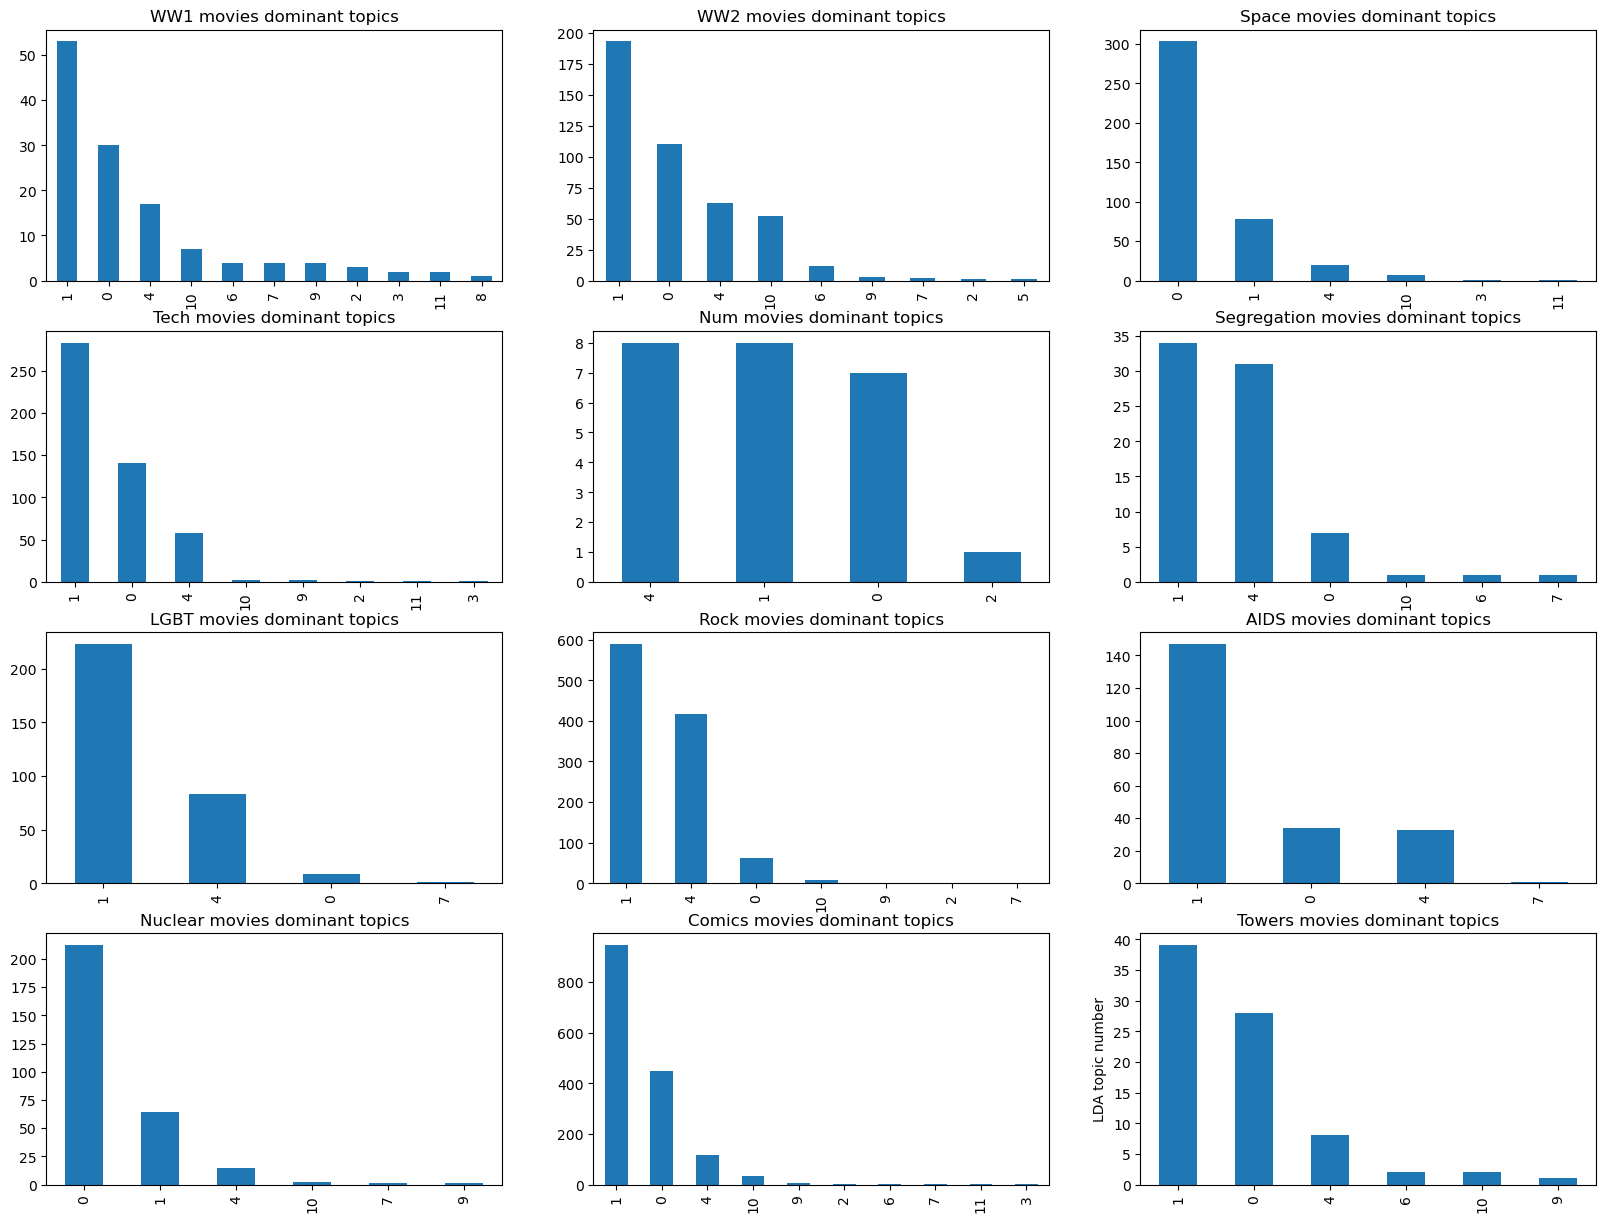

In [167]:
fig, axs = plt.subplots(4, 3, figsize=(20,15))
axravel = axs.ravel()
for i, event in enumerate(dictionnaries.index):
    df_movie_events[df_movie_events['Hist_event'] == event]['Dominant_Topic'].value_counts().plot(ax=axravel[i], kind='bar')
    axravel[i].set_title(f"{event} movies dominant topics")

plt.ylabel('LDA topic number')
plt.show()

Hmmmm.....

## Word2vec analysis

In [168]:
from gensim.models import Word2Vec, KeyedVectors

w2v_model = Word2Vec(df_movie_events["tokenized"],
                     min_count=1, # Ignores all words with total frequency lower than 1.
                     vector_size=100,  # desired number of features
                     window=5, # context window size
                     sg=1, # 1 for skip-gram model
                     negative=10) # for negative sampling

In [169]:
war_vec = w2v_model.wv['war']
print(war_vec)

[ 0.6780871   0.20839433  0.01157378  0.91801804  0.02871168 -0.4555373
 -0.1734536  -0.20306712  0.34762263 -0.45790887  0.72661597 -0.6605033
  0.699897    0.9680992   0.57154375  0.3482298   0.05841762 -0.17165759
 -0.7376906  -0.3921589   0.41765347 -0.10314714  0.21037194  0.5811002
  0.2037156  -0.26979333 -0.279665    0.20032044 -0.23192938  0.22557351
 -0.22468348 -0.35052645  0.00365115  0.26064396 -0.23378865 -0.24634734
  0.29058385  0.5436597  -0.01262594 -0.38426086 -0.32936656 -0.40359008
 -1.3241795   0.67196184  0.07005078 -0.73177665 -1.1899463  -0.3742844
  0.17983553  0.6039778   0.12031494 -0.05739276  0.26437175  0.07584396
 -0.31998506  0.11622938 -0.02309113 -0.6293854  -0.15944836 -0.06490035
 -0.48032743  0.4444932   0.39736742 -0.50072557 -1.0561647   0.43624508
 -0.3066173  -0.8608347   1.0071089  -0.21157272  0.6728923  -0.23417208
 -0.24880728 -0.001835    0.5850919   0.22635157  0.22295474  0.40192902
 -0.2861575  -0.52369434 -0.05983169 -0.2201256   0.144

In [170]:
sim_war = w2v_model.wv.most_similar('war')
print(sim_war)

[('germany', 0.754601240158081), ('west', 0.7314803004264832), ('invasion', 0.7153518199920654), ('france', 0.676359236240387), ('peace', 0.6662489175796509), ('japan', 0.6603701114654541), ('berlin', 0.660311222076416), ('iii', 0.6579535007476807), ('post', 0.6576937437057495), ('adolf', 0.6543574929237366)]


In [171]:
sim_gay = w2v_model.wv.most_similar('gay')
print(sim_gay)

[('lesbian', 0.780207097530365), ('lover', 0.7112413048744202), ('professional', 0.7109461426734924), ('whos', 0.7030463218688965), ('con', 0.7009537816047668), ('living', 0.6991204023361206), ('butch', 0.6988403797149658), ('bar', 0.6967290043830872), ('older', 0.6937066316604614), ('michael', 0.692875325679779)]


In [172]:
sim_tech = w2v_model.wv.most_similar('technology')
print(sim_tech)

[('designed', 0.9704558253288269), ('nation', 0.9621809720993042), ('advanced', 0.961567759513855), ('artificial', 0.9527485966682434), ('nihongo', 0.9505892992019653), ('offensive', 0.9487766623497009), ('silos', 0.9473087787628174), ('egypt', 0.9470773935317993), ('global', 0.944283664226532), ('created', 0.9425813555717468)]


In [173]:
sim_wwii = w2v_model.wv.most_similar('wwii')
print(sim_wwii)

[('departing', 0.9900440573692322), ('viral', 0.9896895885467529), ('everyones', 0.989547610282898), ('retro', 0.9895400404930115), ('outcome', 0.9895342588424683), ('float', 0.989446222782135), ('respite', 0.9894434213638306), ('tours', 0.9894352555274963), ('bustling', 0.9892005920410156), ('belgrade', 0.9886294603347778)]


## Topic detection on raw movie plots

In [ ]:
movies_plot['clean_plot'] = movies_plot['Summary'].apply(lambda x: clean(x))
movies_plot['tokenized']=movies_plot['clean_plot'].apply(lambda x: nltk.word_tokenize(x))
dictionary_plots = corpora.Dictionary(movies_plot['tokenized'])
doc_term_matrix_plots = [dictionary.doc2bow(rev) for rev in movies_plot['tokenized']]

In [ ]:
# Ca met plus de 40 mins à run, jsp si ca vaut la peine de mettre dedans
"""
LDA_plot = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model_plot = LDA_plot(corpus=doc_term_matrix_plots, id2word=dictionary_plots, num_topics=len(movies_event.keys()), random_state=100,
                chunksize=200, passes=100)
"""

In [ ]:
# plot topics
#data =  pyLDAvis.gensim_models.prepare(lda_model_plot, doc_term_matrix_plots, dictionary_plots)
#pyLDAvis.display(data)